# CSE 576 (Spring 2020) Homework 4

Welcome friends, it's time for Deep Learning with PyTorch! This homework might need a longer running time. 
Keep this in mind and start early.

PyTorch is a deep learning framework for fast, flexible experimentation. We are going to use it to train our classifiers.

For this homework you need to turn in this file `hw4.ipynb` after running your results and answering questions in-line.

**Notes**: 
 - This assignment was designed to be used with Google Colab, but feel free to set up your own environment if you wish. Just bear in mind that we cannot provide support for custom environments.
 - Feel free to create new cells as needed, but please **do not delete existing cells**.

Before you get started, we suggest you do the [PyTorch tutorial first](https://github.com/param087/Pytorch-tutorial-on-Google-colab).

You should at least do the 60 Minute Blitz up until "Training a Classifier".

**How to use this notebook:**
 - Each cell with a grey background is executable.
 - They can be executed by pressing the "Play" button or by hitting `Shift+Enter`
 - Cells can be executed out of order.
 - You can add new cells by clicking on the `+ Code` button in the header.
 - Made a mistake a need to start over? Click *(Runtime => Restart runtime)*
 - Check out this [Colab Introduction](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) if you're having trouble.


 This will make sure that your progress will be saved to your Google Drive, and won't be lost if your browser refreshes for some reason. 

## Setup

This will set up the environment without GPUs. This is the recommended setup.

In [0]:
! pip install torch==1.5.0+cpu torchvision==0.6.0+cpu -f https://download.pytorch.org/whl/torch_stable.html 
! pip install tqdm matplotlib

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
# We're not using the GPU.
use_gpu = False

### With GPUs
If you're feeling adventurous you can use GPUs to accelerate training. Follow the following steps. Just note that GPUs might not be available. The course staff also can't provide support for GPU-related issues so if you're having trouble please just use the CPU runtime.

 1. Go to Runtime > Change runtime type and select 'GPU'
 2. Restart the Runtime, uncomment the commands below and run them.

In [0]:
# Install the necessary packages

# ! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html 
# ! pip install tqdm matplotlib

If you want to use the GPU, uncomment the line below and run it.

In [0]:
# Uncomment this and execute if you're using the GPU.
# use_gpu = True

### Check that things are working.

In [2]:
# Make sure things work.

import torch

if use_gpu:
    print(torch.zeros(10).cuda())
else:
    print(torch.zeros(10))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


 ## Initialize Datasets

 This code defines the data loaders that will be used to train and test our networks. It also defines data augmentation functions.

In [3]:
import torch
import torchvision
from torchvision import transforms

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

default_train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize rescales and shifts the data so that it has a zero mean 
    # and unit variance. This reduces bias and makes it easier to learn!
    # The values here are the mean and variance of our inputs.
    # This will change the input images to be centered at 0 and be 
    # between -1 and 1.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

default_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])


def get_train_loader(batch_size, transform=default_train_transform):
    trainset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform)
    return torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=4)


def get_test_loader(batch_size, transform=default_test_transform):
    testset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform) 
    return torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=4)


# This downloads the datasets.
get_train_loader(1)
get_test_loader(1);

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define code that trains and tests code.

This code will train your model. Feel free to read the code below, but we suggest you don't modify it unless you know what you're doing.

In [0]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# The function we'll call to train the network each epoch
def train(net, loader, optimizer, criterion, epoch, use_gpu=False):
    running_loss = 0.0
    total_loss = 0.0

    # Send the network to the correct device
    if use_gpu:
        net = net.cuda()
    else:
        net = net.cpu()

    # tqdm is a useful package for adding a progress bar to your loops
    pbar = tqdm(loader)
    for i, data in enumerate(pbar):
        inputs, labels = data

        # If we're using the GPU, send the data to the GPU
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()  # Set the gradients of the parameters to zero.
        outputs = net(inputs)  # Forward pass (send the images through the network)
        loss = criterion(outputs, labels)  # Compute the loss w.r.t the labels.
        loss.backward()  # Backward pass (compute gradients).
        optimizer.step()  # Use the gradients to update the weights of the network.

        running_loss += loss.item()
        total_loss += loss.item()
        pbar.set_description(f"[epoch {epoch+1}] loss = {running_loss/(i+1):.03f}")
    
    average_loss = total_loss / (i + 1)
    tqdm.write(f"Epoch {epoch} summary -- loss = {average_loss:.03f}")
    
    return average_loss


This code will evaluate the performance of you network. It won't update the weights, just compute from evaluation metrics.

In [0]:
from collections import defaultdict
from torchvision.utils import make_grid
from PIL import Image
from IPython import display as ipd


def show_hard_negatives(hard_negatives, label, nrow=10):
    """Visualizes hard negatives"""
    grid = make_grid([(im+1)/2 for im, score in hard_negatives[label]], 
                     nrow=nrow, padding=1)
    grid = grid.permute(1, 2, 0).mul(255).byte().numpy()
    ipd.display(Image.fromarray((grid)))


# The function we'll call to test the network
def test(net, loader, tag='', use_gpu=False, num_hard_negatives=10):
    correct = 0
    total = 0

    # Send the network to the correct device
    net = net.cuda() if use_gpu else net.cpu()

    # Compute the overall accuracy of the network
    with torch.no_grad():
        for data in tqdm(loader, desc=f"Evaluating {tag}"):
            images, labels = data

            # If we're using the GPU, send the data to the GPU
            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # Forward pass (send the images through the network)
            outputs = net(images)

            # Take the output of the network, and extract the index 
            # of the largest prediction for each example
            _, predicted = torch.max(outputs.data, 1)

            # Count the number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    average_accuracy = correct/total
    tqdm.write(f'{tag} accuracy of the network: {100*average_accuracy:.02f}%')

    # Repeat above, but estimate the testing accuracy for each of the labels
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    hard_negatives = defaultdict(list)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()
            outputs = net(images)
            predicted_scores, predicted_labels = torch.max(outputs, 1)
            correct_mask = (predicted_labels == labels).squeeze()
            incorrect_mask = ~correct_mask
            unique_labels, unique_counts = torch.unique(labels, return_counts=True)
            for l, c in zip(unique_labels, unique_counts):
                l = l.item()
                label_mask = (labels == l)
                predicted_mask = (predicted_labels == l)
                # This keeps track of the most hardest negatives
                # i.e. mistakes with the highest confidence.
                hard_negative_mask = (~correct_mask & predicted_mask)
                if hard_negative_mask.sum() > 0:
                    hard_negatives[l].extend([
                        (im, score.item()) 
                        for im, score in zip(images[hard_negative_mask], 
                                             predicted_scores[hard_negative_mask])])
                    hard_negatives[l].sort(key=lambda x: x[1], reverse=True)
                    hard_negatives[l] = hard_negatives[l][:num_hard_negatives]
                class_correct[l] += (correct_mask & label_mask).sum()
                class_total[l] += c


    for i in range(10):
        tqdm.write(f'{tag} accuracy of {classes[i]} = {100*class_correct[i]/class_total[i]:.02f}%')
        print(f'Hard negatives for {classes[i]}')
        # show_hard_negatives(hard_negatives, i, nrow=10)

    
    return average_accuracy

This is a wrapper function we provide that handles all the book keeping. It will train your network for an epoch and then test it every couple epochs.

In [0]:
def train_network(net, 
                  lr, 
                  epochs, 
                  batch_size, 
                  criterion=None,
                  lr_func=None,
                  train_transform=default_train_transform, 
                  eval_interval=10,
                  use_gpu=use_gpu): 
    # Initialize the optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)

    # Initialize the loss function
    if criterion is None:
        # Note that CrossEntropyLoss has the Softmax built in!
        # This is good for numerical stability. 
        # Read: https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()

    # Initialize the data loaders
    train_loader = get_train_loader(batch_size, transform=train_transform)
    test_loader = get_test_loader(batch_size)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        if lr_func is not None:
            lr_func(optimizer, epoch, lr)

        train_loss = train(net, train_loader, optimizer, criterion, epoch, use_gpu=use_gpu)
        train_losses.append(train_loss)

        # Evaluate the model every `eval_interval` epochs.
        if (epoch + 1) % eval_interval == 0:
            print(f"Evaluating epoch {epoch+1}")
            train_accuracy = test(net, train_loader, 'Train', use_gpu=use_gpu)
            test_accuracy = test(net, test_loader, 'Test', use_gpu=use_gpu)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
    
    return train_losses, train_accuracies, test_accuracies
    

# A function to plot the losses over time
def plot_results(train_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].plot(train_losses)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    
    axes[1].plot(train_accuracies)
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    
    axes[2].plot(test_accuracies)
    axes[2].set_title('Testing Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')



## 2.1. Training a classifier using only one fully connected Layer

Implement a model to classify the images from Cifar-10 into ten categories using just one fully connected layer (remember that fully connected layers are called Linear in PyTorch).

If you are new to PyTorch you may want to check out the tutorial on MNIST [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

Fill in the code for LazyNet here.

**Hints:**
 - Note that `nn.CrossEntropyLoss` has the Softmax built in for numerical stability. This means that the output layer of your network should be linear and not contain a Softmax. You can read more about it [here](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
 - You can use the `view()` function to flatten your input image to a vector e.g., if `x` is a `(100,3,4,4)` tensor then `x.view(-1, 3*4*4)` will flatten it into a vector of size `48`.
 - The images in MNIST are 32x32.

In [7]:
from torch import nn
from torch import optim
import torch.nn.functional as F

class LazyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        
        self.fc1 = nn.Linear(32 * 32 * 3, 100)
        self.fc2 = nn.Linear(100, 10)
      

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        # x.size() = 1024, 3, 32, 32
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        return x

net = LazyNet()
net

LazyNet(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

#### Run the model for 15 epochs and report the plots and accuracies.

In [0]:
train_losses_one_layer, train_accuracies_one_layer, test_accuracies_one_layer = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=15,
    eval_interval=5,
    batch_size=1024)


Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.233



Epoch 1 summary -- loss = 2.120



Epoch 2 summary -- loss = 2.047



Epoch 3 summary -- loss = 1.991



Epoch 4 summary -- loss = 1.945
Evaluating epoch 5



Train accuracy of the network: 34.16%
Train accuracy of plane = 44.02%
Hard negatives for plane
Train accuracy of car = 32.02%
Hard negatives for car
Train accuracy of bird = 17.76%
Hard negatives for bird
Train accuracy of cat = 2.82%
Hard negatives for cat
Train accuracy of deer = 31.52%
Hard negatives for deer
Train accuracy of dog = 34.04%
Hard negatives for dog
Train accuracy of frog = 49.08%
Hard negatives for frog
Train accuracy of horse = 30.44%
Hard negatives for horse
Train accuracy of ship = 49.96%
Hard negatives for ship
Train accuracy of truck = 49.92%
Hard negatives for truck



Test accuracy of the network: 34.95%
Test accuracy of plane = 46.60%
Hard negatives for plane
Test accuracy of car = 32.80%
Hard negatives for car
Test accuracy of bird = 17.90%
Hard negatives for bird
Test accuracy of cat = 2.40%
Hard negatives for cat
Test accuracy of deer = 31.20%
Hard negatives for deer
Test accuracy of dog = 32.90%
Hard negatives for dog
Test accuracy of frog = 52.10%
Hard negatives for frog
Test accuracy of horse = 31.40%
Hard negatives for horse
Test accuracy of ship = 51.90%
Hard negatives for ship
Test accuracy of truck = 50.30%
Hard negatives for truck



Epoch 5 summary -- loss = 1.908



Epoch 6 summary -- loss = 1.877



Epoch 7 summary -- loss = 1.852



Epoch 8 summary -- loss = 1.830



Epoch 9 summary -- loss = 1.812
Evaluating epoch 10



Train accuracy of the network: 37.43%
Train accuracy of plane = 45.20%
Hard negatives for plane
Train accuracy of car = 41.96%
Hard negatives for car
Train accuracy of bird = 19.92%
Hard negatives for bird
Train accuracy of cat = 8.30%
Hard negatives for cat
Train accuracy of deer = 33.30%
Hard negatives for deer
Train accuracy of dog = 37.18%
Hard negatives for dog
Train accuracy of frog = 49.62%
Hard negatives for frog
Train accuracy of horse = 38.70%
Hard negatives for horse
Train accuracy of ship = 52.46%
Hard negatives for ship
Train accuracy of truck = 47.64%
Hard negatives for truck



Test accuracy of the network: 37.67%
Test accuracy of plane = 45.60%
Hard negatives for plane
Test accuracy of car = 42.00%
Hard negatives for car
Test accuracy of bird = 19.90%
Hard negatives for bird
Test accuracy of cat = 8.50%
Hard negatives for cat
Test accuracy of deer = 33.40%
Hard negatives for deer
Test accuracy of dog = 35.50%
Hard negatives for dog
Test accuracy of frog = 51.60%
Hard negatives for frog
Test accuracy of horse = 39.10%
Hard negatives for horse
Test accuracy of ship = 53.40%
Hard negatives for ship
Test accuracy of truck = 47.70%
Hard negatives for truck



Epoch 10 summary -- loss = 1.795



Epoch 11 summary -- loss = 1.780



Epoch 12 summary -- loss = 1.766



Epoch 13 summary -- loss = 1.753



Epoch 14 summary -- loss = 1.742
Evaluating epoch 15



Train accuracy of the network: 39.65%
Train accuracy of plane = 45.42%
Hard negatives for plane
Train accuracy of car = 46.34%
Hard negatives for car
Train accuracy of bird = 23.28%
Hard negatives for bird
Train accuracy of cat = 16.78%
Hard negatives for cat
Train accuracy of deer = 32.82%
Hard negatives for deer
Train accuracy of dog = 35.70%
Hard negatives for dog
Train accuracy of frog = 50.12%
Hard negatives for frog
Train accuracy of horse = 43.24%
Hard negatives for horse
Train accuracy of ship = 54.50%
Hard negatives for ship
Train accuracy of truck = 48.26%
Hard negatives for truck



Test accuracy of the network: 39.84%
Test accuracy of plane = 45.70%
Hard negatives for plane
Test accuracy of car = 46.80%
Hard negatives for car
Test accuracy of bird = 24.10%
Hard negatives for bird
Test accuracy of cat = 15.90%
Hard negatives for cat
Test accuracy of deer = 33.30%
Hard negatives for deer
Test accuracy of dog = 33.70%
Hard negatives for dog
Test accuracy of frog = 51.70%
Hard negatives for frog
Test accuracy of horse = 43.90%
Hard negatives for horse
Test accuracy of ship = 54.60%
Hard negatives for ship
Test accuracy of truck = 48.70%
Hard negatives for truck


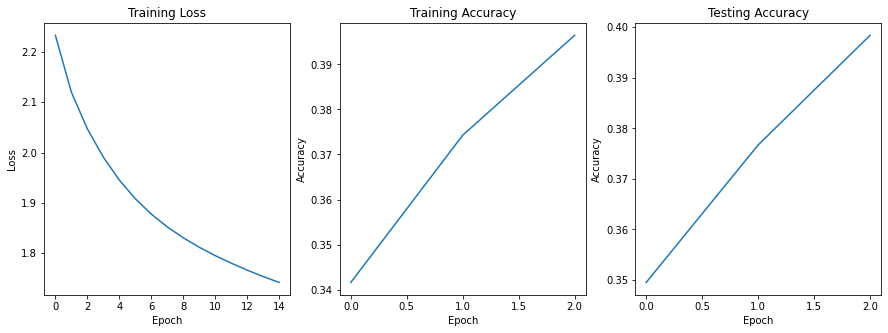

In [0]:
plot_results(train_losses_one_layer, train_accuracies_one_layer, test_accuracies_one_layer)

## 2.2. Training a classifier using multiple fully connected layers ##

Implement a model for the same classification task using multiple fully connected layers.

Start with a fully connected layer that maps the data from image size (32 * 32 * 3) to a vector of size 120, followed by another fully connected that reduces the size to 84 and finally a layer that maps the vector of size 84 to 10 classes.

Use any activation you want.

Fill in the code for BoringNet below.

In [0]:
class BoringNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = BoringNet()
net

BoringNet(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Run the model for 30 epochs and report the plots and accuracies.

In [0]:
train_losses_three_layers, train_accuracies_three_layers, test_accuracies_three_layers = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.291



Epoch 1 summary -- loss = 2.260



Epoch 2 summary -- loss = 2.223



Epoch 3 summary -- loss = 2.179



Epoch 4 summary -- loss = 2.135



Epoch 5 summary -- loss = 2.095



Epoch 6 summary -- loss = 2.059



Epoch 7 summary -- loss = 2.027



Epoch 8 summary -- loss = 1.997



Epoch 9 summary -- loss = 1.970
Evaluating epoch 10



Train accuracy of the network: 30.53%
Train accuracy of plane = 43.66%
Hard negatives for plane
Train accuracy of car = 30.90%
Hard negatives for car
Train accuracy of bird = 1.84%
Hard negatives for bird
Train accuracy of cat = 4.08%
Hard negatives for cat
Train accuracy of deer = 6.48%
Hard negatives for deer
Train accuracy of dog = 29.80%
Hard negatives for dog
Train accuracy of frog = 62.62%
Hard negatives for frog
Train accuracy of horse = 24.76%
Hard negatives for horse
Train accuracy of ship = 51.44%
Hard negatives for ship
Train accuracy of truck = 49.72%
Hard negatives for truck



Test accuracy of the network: 30.83%
Test accuracy of plane = 47.30%
Hard negatives for plane
Test accuracy of car = 30.80%
Hard negatives for car
Test accuracy of bird = 1.80%
Hard negatives for bird
Test accuracy of cat = 4.20%
Hard negatives for cat
Test accuracy of deer = 5.80%
Hard negatives for deer
Test accuracy of dog = 28.90%
Hard negatives for dog
Test accuracy of frog = 63.30%
Hard negatives for frog
Test accuracy of horse = 25.90%
Hard negatives for horse
Test accuracy of ship = 51.10%
Hard negatives for ship
Test accuracy of truck = 49.20%
Hard negatives for truck



Epoch 10 summary -- loss = 1.947



Epoch 11 summary -- loss = 1.925



Epoch 12 summary -- loss = 1.905



Epoch 13 summary -- loss = 1.887



Epoch 14 summary -- loss = 1.870



Epoch 15 summary -- loss = 1.855



Epoch 16 summary -- loss = 1.840



Epoch 17 summary -- loss = 1.826



Epoch 18 summary -- loss = 1.814



Epoch 19 summary -- loss = 1.801
Evaluating epoch 20



Train accuracy of the network: 36.63%
Train accuracy of plane = 45.16%
Hard negatives for plane
Train accuracy of car = 48.26%
Hard negatives for car
Train accuracy of bird = 12.68%
Hard negatives for bird
Train accuracy of cat = 7.08%
Hard negatives for cat
Train accuracy of deer = 27.46%
Hard negatives for deer
Train accuracy of dog = 40.60%
Hard negatives for dog
Train accuracy of frog = 49.20%
Hard negatives for frog
Train accuracy of horse = 38.88%
Hard negatives for horse
Train accuracy of ship = 51.86%
Hard negatives for ship
Train accuracy of truck = 45.12%
Hard negatives for truck



Test accuracy of the network: 36.67%
Test accuracy of plane = 46.50%
Hard negatives for plane
Test accuracy of car = 48.40%
Hard negatives for car
Test accuracy of bird = 13.20%
Hard negatives for bird
Test accuracy of cat = 6.80%
Hard negatives for cat
Test accuracy of deer = 26.20%
Hard negatives for deer
Test accuracy of dog = 38.30%
Hard negatives for dog
Test accuracy of frog = 51.30%
Hard negatives for frog
Test accuracy of horse = 39.40%
Hard negatives for horse
Test accuracy of ship = 51.90%
Hard negatives for ship
Test accuracy of truck = 44.70%
Hard negatives for truck



Epoch 20 summary -- loss = 1.790



Epoch 21 summary -- loss = 1.779



Epoch 22 summary -- loss = 1.768



Epoch 23 summary -- loss = 1.758



Epoch 24 summary -- loss = 1.749



Epoch 25 summary -- loss = 1.739



Epoch 26 summary -- loss = 1.731



Epoch 27 summary -- loss = 1.722



Epoch 28 summary -- loss = 1.714



Epoch 29 summary -- loss = 1.706
Evaluating epoch 30



Train accuracy of the network: 40.07%
Train accuracy of plane = 44.74%
Hard negatives for plane
Train accuracy of car = 51.66%
Hard negatives for car
Train accuracy of bird = 23.32%
Hard negatives for bird
Train accuracy of cat = 16.28%
Hard negatives for cat
Train accuracy of deer = 28.76%
Hard negatives for deer
Train accuracy of dog = 37.96%
Hard negatives for dog
Train accuracy of frog = 51.64%
Hard negatives for frog
Train accuracy of horse = 43.14%
Hard negatives for horse
Train accuracy of ship = 55.96%
Hard negatives for ship
Train accuracy of truck = 47.24%
Hard negatives for truck



Test accuracy of the network: 40.22%
Test accuracy of plane = 46.80%
Hard negatives for plane
Test accuracy of car = 51.70%
Hard negatives for car
Test accuracy of bird = 23.90%
Hard negatives for bird
Test accuracy of cat = 15.00%
Hard negatives for cat
Test accuracy of deer = 29.00%
Hard negatives for deer
Test accuracy of dog = 37.00%
Hard negatives for dog
Test accuracy of frog = 51.40%
Hard negatives for frog
Test accuracy of horse = 44.30%
Hard negatives for horse
Test accuracy of ship = 55.80%
Hard negatives for ship
Test accuracy of truck = 47.30%
Hard negatives for truck


In [0]:
class BoringNetWithout(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

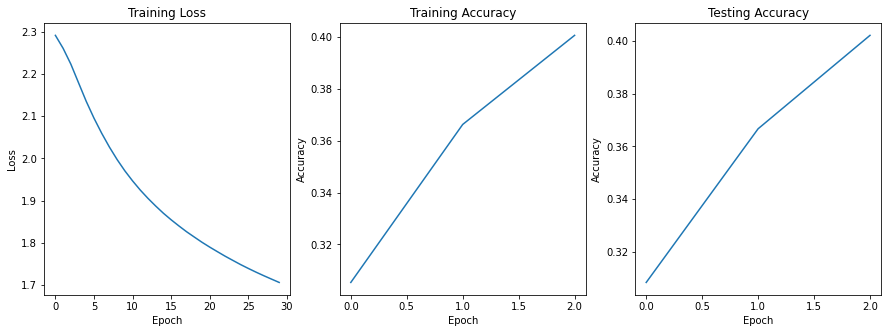

In [0]:
plot_results(train_losses_three_layers, train_accuracies_three_layers, test_accuracies_three_layers)

In [0]:
net = BoringNetWithout()
train_losses_three_layers_without, train_accuracies_three_layers_without, test_accuracies_three_layers_without = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.223



Epoch 1 summary -- loss = 2.110



Epoch 2 summary -- loss = 2.041



Epoch 3 summary -- loss = 1.992



Epoch 4 summary -- loss = 1.957



Epoch 5 summary -- loss = 1.930



Epoch 6 summary -- loss = 1.909



Epoch 7 summary -- loss = 1.892



Epoch 8 summary -- loss = 1.877



Epoch 9 summary -- loss = 1.864
Evaluating epoch 10



Train accuracy of the network: 36.14%
Train accuracy of plane = 43.20%
Hard negatives for plane
Train accuracy of car = 40.30%
Hard negatives for car
Train accuracy of bird = 10.26%
Hard negatives for bird
Train accuracy of cat = 7.64%
Hard negatives for cat
Train accuracy of deer = 33.02%
Hard negatives for deer
Train accuracy of dog = 37.44%
Hard negatives for dog
Train accuracy of frog = 52.54%
Hard negatives for frog
Train accuracy of horse = 35.66%
Hard negatives for horse
Train accuracy of ship = 50.82%
Hard negatives for ship
Train accuracy of truck = 50.56%
Hard negatives for truck



Test accuracy of the network: 36.17%
Test accuracy of plane = 45.20%
Hard negatives for plane
Test accuracy of car = 40.40%
Hard negatives for car
Test accuracy of bird = 10.50%
Hard negatives for bird
Test accuracy of cat = 8.40%
Hard negatives for cat
Test accuracy of deer = 32.50%
Hard negatives for deer
Test accuracy of dog = 35.60%
Hard negatives for dog
Test accuracy of frog = 53.20%
Hard negatives for frog
Test accuracy of horse = 35.50%
Hard negatives for horse
Test accuracy of ship = 50.30%
Hard negatives for ship
Test accuracy of truck = 50.10%
Hard negatives for truck



Epoch 10 summary -- loss = 1.853



Epoch 11 summary -- loss = 1.843



Epoch 12 summary -- loss = 1.834



Epoch 13 summary -- loss = 1.827



Epoch 14 summary -- loss = 1.819



Epoch 15 summary -- loss = 1.813



Epoch 16 summary -- loss = 1.807



Epoch 17 summary -- loss = 1.801



Epoch 18 summary -- loss = 1.796



Epoch 19 summary -- loss = 1.791
Evaluating epoch 20



Train accuracy of the network: 38.65%
Train accuracy of plane = 44.32%
Hard negatives for plane
Train accuracy of car = 45.84%
Hard negatives for car
Train accuracy of bird = 19.98%
Hard negatives for bird
Train accuracy of cat = 17.94%
Hard negatives for cat
Train accuracy of deer = 30.04%
Hard negatives for deer
Train accuracy of dog = 34.78%
Hard negatives for dog
Train accuracy of frog = 51.32%
Hard negatives for frog
Train accuracy of horse = 41.32%
Hard negatives for horse
Train accuracy of ship = 51.52%
Hard negatives for ship
Train accuracy of truck = 49.46%
Hard negatives for truck



Test accuracy of the network: 38.63%
Test accuracy of plane = 45.80%
Hard negatives for plane
Test accuracy of car = 45.50%
Hard negatives for car
Test accuracy of bird = 20.70%
Hard negatives for bird
Test accuracy of cat = 18.50%
Hard negatives for cat
Test accuracy of deer = 29.30%
Hard negatives for deer
Test accuracy of dog = 32.60%
Hard negatives for dog
Test accuracy of frog = 51.90%
Hard negatives for frog
Test accuracy of horse = 40.60%
Hard negatives for horse
Test accuracy of ship = 51.40%
Hard negatives for ship
Test accuracy of truck = 50.00%
Hard negatives for truck



Epoch 20 summary -- loss = 1.786



Epoch 21 summary -- loss = 1.782



Epoch 22 summary -- loss = 1.778



Epoch 23 summary -- loss = 1.773



Epoch 24 summary -- loss = 1.770



Epoch 25 summary -- loss = 1.766



Epoch 26 summary -- loss = 1.763



Epoch 27 summary -- loss = 1.760



Epoch 28 summary -- loss = 1.756



Epoch 29 summary -- loss = 1.753
Evaluating epoch 30



Train accuracy of the network: 39.96%
Train accuracy of plane = 45.28%
Hard negatives for plane
Train accuracy of car = 48.20%
Hard negatives for car
Train accuracy of bird = 22.96%
Hard negatives for bird
Train accuracy of cat = 23.64%
Hard negatives for cat
Train accuracy of deer = 28.66%
Hard negatives for deer
Train accuracy of dog = 34.02%
Hard negatives for dog
Train accuracy of frog = 51.62%
Hard negatives for frog
Train accuracy of horse = 43.32%
Hard negatives for horse
Train accuracy of ship = 51.48%
Hard negatives for ship
Train accuracy of truck = 50.42%
Hard negatives for truck



Test accuracy of the network: 39.80%
Test accuracy of plane = 46.70%
Hard negatives for plane
Test accuracy of car = 48.30%
Hard negatives for car
Test accuracy of bird = 22.90%
Hard negatives for bird
Test accuracy of cat = 23.30%
Hard negatives for cat
Test accuracy of deer = 28.20%
Hard negatives for deer
Test accuracy of dog = 32.40%
Hard negatives for dog
Test accuracy of frog = 53.00%
Hard negatives for frog
Test accuracy of horse = 42.90%
Hard negatives for horse
Test accuracy of ship = 50.80%
Hard negatives for ship
Test accuracy of truck = 49.50%
Hard negatives for truck


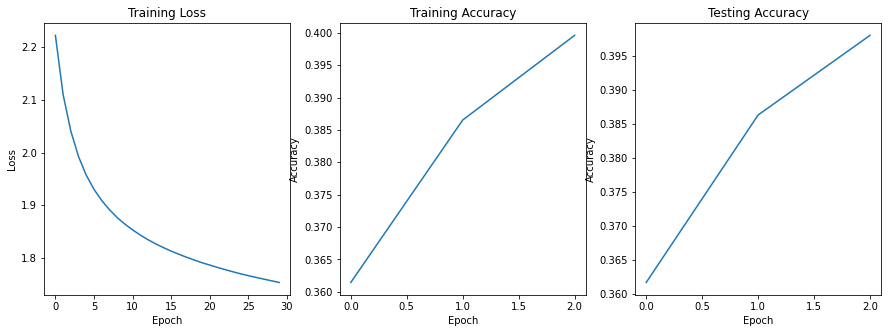

In [0]:
plot_results(train_losses_three_layers_without, train_accuracies_three_layers_without, test_accuracies_three_layers_without)

### Question

Try training this model with and without activations. How does the activations (such as ReLU) affect the training process and why?


###Answer
Model with ReLu activation function can prevent overfitting. The reason is some weights will update to 0 and made the network more sparsely. In this cases, the training loss without Relu gives a sharp drop down, which tends to overfit the training data. On the other hand, the training loss with Relu activation function gives a smoothly curve. 

The reason of two results is quite similar is because the weight had not been updated too mamy times. Also, this is a simple model with only one layer. However, we can still see the affect that Relu made on training loss.



## 2.3. Training a classifier using convolutions ##

Implement a model using convolutional, pooling and fully connected layers.

You are free to choose any parameters for these layers (we would like you to play around with some values).

Fill in the code for CoolNet below. Explain why you have chosen these layers and how they affected the performance. Analyze the behavior of your model and report the plots in your report file.

In [9]:

class CoolNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # 3*32*32->16*32*32
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 16*16*16->32*16*16
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*8*8, 120) 
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
      
        return x

net = CoolNet()
net

CoolNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

#Model Inspection:
The model is built by two convolution layers by max pooling. Extract the feature and lower the hyprparameter to fasten the training.

### Run the model for 30 epochs and report the plots and accuracies 

In [0]:
net = CoolNet()
train_losses_1024, train_accuracies_1024, test_accuracies_1024 = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.303



Epoch 1 summary -- loss = 2.298



Epoch 2 summary -- loss = 2.293



Epoch 3 summary -- loss = 2.286



Epoch 4 summary -- loss = 2.277



Epoch 5 summary -- loss = 2.263



Epoch 6 summary -- loss = 2.242



Epoch 7 summary -- loss = 2.212



Epoch 8 summary -- loss = 2.171



Epoch 9 summary -- loss = 2.131
Evaluating epoch 10



Train accuracy of the network: 26.68%
Train accuracy of plane = 32.18%
Hard negatives for plane
Train accuracy of car = 27.50%
Hard negatives for car
Train accuracy of bird = 9.68%
Hard negatives for bird
Train accuracy of cat = 9.28%
Hard negatives for cat
Train accuracy of deer = 13.68%
Hard negatives for deer
Train accuracy of dog = 25.64%
Hard negatives for dog
Train accuracy of frog = 32.38%
Hard negatives for frog
Train accuracy of horse = 32.34%
Hard negatives for horse
Train accuracy of ship = 23.40%
Hard negatives for ship
Train accuracy of truck = 60.68%
Hard negatives for truck



Test accuracy of the network: 27.04%
Test accuracy of plane = 34.40%
Hard negatives for plane
Test accuracy of car = 28.50%
Hard negatives for car
Test accuracy of bird = 12.10%
Hard negatives for bird
Test accuracy of cat = 8.50%
Hard negatives for cat
Test accuracy of deer = 12.10%
Hard negatives for deer
Test accuracy of dog = 25.00%
Hard negatives for dog
Test accuracy of frog = 33.40%
Hard negatives for frog
Test accuracy of horse = 30.00%
Hard negatives for horse
Test accuracy of ship = 26.30%
Hard negatives for ship
Test accuracy of truck = 60.10%
Hard negatives for truck



Epoch 10 summary -- loss = 2.096



Epoch 11 summary -- loss = 2.063



Epoch 12 summary -- loss = 2.028



Epoch 13 summary -- loss = 1.990



Epoch 14 summary -- loss = 1.949



Epoch 15 summary -- loss = 1.908



Epoch 16 summary -- loss = 1.871



Epoch 17 summary -- loss = 1.841



Epoch 18 summary -- loss = 1.816



Epoch 19 summary -- loss = 1.795
Evaluating epoch 20



Train accuracy of the network: 37.52%
Train accuracy of plane = 48.62%
Hard negatives for plane
Train accuracy of car = 40.84%
Hard negatives for car
Train accuracy of bird = 25.54%
Hard negatives for bird
Train accuracy of cat = 23.80%
Hard negatives for cat
Train accuracy of deer = 23.38%
Hard negatives for deer
Train accuracy of dog = 26.52%
Hard negatives for dog
Train accuracy of frog = 55.48%
Hard negatives for frog
Train accuracy of horse = 35.28%
Hard negatives for horse
Train accuracy of ship = 47.42%
Hard negatives for ship
Train accuracy of truck = 48.34%
Hard negatives for truck



Test accuracy of the network: 37.74%
Test accuracy of plane = 50.50%
Hard negatives for plane
Test accuracy of car = 40.60%
Hard negatives for car
Test accuracy of bird = 24.60%
Hard negatives for bird
Test accuracy of cat = 22.50%
Hard negatives for cat
Test accuracy of deer = 24.10%
Hard negatives for deer
Test accuracy of dog = 26.60%
Hard negatives for dog
Test accuracy of frog = 57.80%
Hard negatives for frog
Test accuracy of horse = 36.70%
Hard negatives for horse
Test accuracy of ship = 48.40%
Hard negatives for ship
Test accuracy of truck = 45.60%
Hard negatives for truck



Epoch 20 summary -- loss = 1.776



Epoch 21 summary -- loss = 1.758



Epoch 22 summary -- loss = 1.740



Epoch 23 summary -- loss = 1.723



Epoch 24 summary -- loss = 1.706



Epoch 25 summary -- loss = 1.692



Epoch 26 summary -- loss = 1.677



Epoch 27 summary -- loss = 1.661



Epoch 28 summary -- loss = 1.646



Epoch 29 summary -- loss = 1.630
Evaluating epoch 30



Train accuracy of the network: 42.93%
Train accuracy of plane = 52.86%
Hard negatives for plane
Train accuracy of car = 48.42%
Hard negatives for car
Train accuracy of bird = 25.64%
Hard negatives for bird
Train accuracy of cat = 13.78%
Hard negatives for cat
Train accuracy of deer = 33.68%
Hard negatives for deer
Train accuracy of dog = 40.66%
Hard negatives for dog
Train accuracy of frog = 55.34%
Hard negatives for frog
Train accuracy of horse = 51.56%
Hard negatives for horse
Train accuracy of ship = 54.28%
Hard negatives for ship
Train accuracy of truck = 53.08%
Hard negatives for truck



Test accuracy of the network: 42.89%
Test accuracy of plane = 53.90%
Hard negatives for plane
Test accuracy of car = 48.70%
Hard negatives for car
Test accuracy of bird = 26.00%
Hard negatives for bird
Test accuracy of cat = 11.60%
Hard negatives for cat
Test accuracy of deer = 32.90%
Hard negatives for deer
Test accuracy of dog = 39.40%
Hard negatives for dog
Test accuracy of frog = 57.60%
Hard negatives for frog
Test accuracy of horse = 51.20%
Hard negatives for horse
Test accuracy of ship = 56.40%
Hard negatives for ship
Test accuracy of truck = 51.20%
Hard negatives for truck


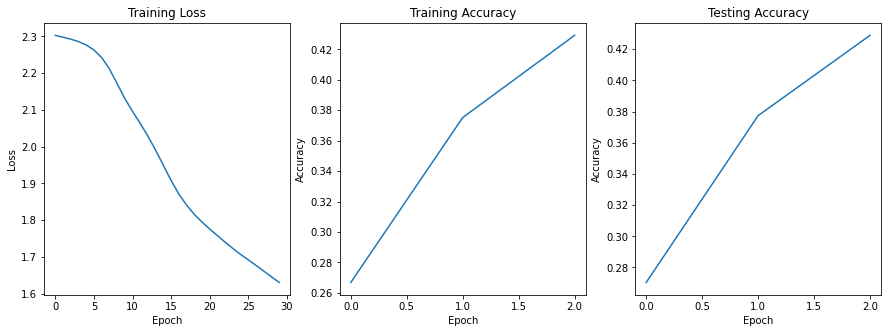

In [0]:
plot_results(train_losses_1024, train_accuracies_1024, test_accuracies_1024)

### 2.3.1. How does batch size affect training?

Try using three different values for batch size. How do these values affect training and why?

In [0]:
# TODO: Your code here
net2 = CoolNet()
train_losses_512, train_accuracies_512, test_accuracies_512 = train_network(
    net2, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    batch_size=512)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.294



Epoch 1 summary -- loss = 2.271



Epoch 2 summary -- loss = 2.231



Epoch 3 summary -- loss = 2.166



Epoch 4 summary -- loss = 2.090



Epoch 5 summary -- loss = 2.024



Epoch 6 summary -- loss = 1.975



Epoch 7 summary -- loss = 1.937



Epoch 8 summary -- loss = 1.903



Epoch 9 summary -- loss = 1.868
Evaluating epoch 10



Train accuracy of the network: 34.95%
Train accuracy of plane = 41.92%
Hard negatives for plane
Train accuracy of car = 39.00%
Hard negatives for car
Train accuracy of bird = 12.36%
Hard negatives for bird
Train accuracy of cat = 19.80%
Hard negatives for cat
Train accuracy of deer = 6.02%
Hard negatives for deer
Train accuracy of dog = 39.04%
Hard negatives for dog
Train accuracy of frog = 59.40%
Hard negatives for frog
Train accuracy of horse = 33.14%
Hard negatives for horse
Train accuracy of ship = 50.52%
Hard negatives for ship
Train accuracy of truck = 48.30%
Hard negatives for truck



Test accuracy of the network: 35.37%
Test accuracy of plane = 44.40%
Hard negatives for plane
Test accuracy of car = 40.20%
Hard negatives for car
Test accuracy of bird = 12.70%
Hard negatives for bird
Test accuracy of cat = 17.80%
Hard negatives for cat
Test accuracy of deer = 6.40%
Hard negatives for deer
Test accuracy of dog = 39.80%
Hard negatives for dog
Test accuracy of frog = 59.50%
Hard negatives for frog
Test accuracy of horse = 33.80%
Hard negatives for horse
Test accuracy of ship = 50.60%
Hard negatives for ship
Test accuracy of truck = 48.50%
Hard negatives for truck



Epoch 10 summary -- loss = 1.831



Epoch 11 summary -- loss = 1.794



Epoch 12 summary -- loss = 1.759



Epoch 13 summary -- loss = 1.727



Epoch 14 summary -- loss = 1.696



Epoch 15 summary -- loss = 1.664



Epoch 16 summary -- loss = 1.631



Epoch 17 summary -- loss = 1.599



Epoch 18 summary -- loss = 1.568



Epoch 19 summary -- loss = 1.535
Evaluating epoch 20



Train accuracy of the network: 45.77%
Train accuracy of plane = 42.70%
Hard negatives for plane
Train accuracy of car = 64.14%
Hard negatives for car
Train accuracy of bird = 19.24%
Hard negatives for bird
Train accuracy of cat = 29.74%
Hard negatives for cat
Train accuracy of deer = 29.44%
Hard negatives for deer
Train accuracy of dog = 33.18%
Hard negatives for dog
Train accuracy of frog = 65.28%
Hard negatives for frog
Train accuracy of horse = 54.26%
Hard negatives for horse
Train accuracy of ship = 64.36%
Hard negatives for ship
Train accuracy of truck = 55.32%
Hard negatives for truck



Test accuracy of the network: 45.86%
Test accuracy of plane = 43.10%
Hard negatives for plane
Test accuracy of car = 65.40%
Hard negatives for car
Test accuracy of bird = 19.60%
Hard negatives for bird
Test accuracy of cat = 28.00%
Hard negatives for cat
Test accuracy of deer = 27.70%
Hard negatives for deer
Test accuracy of dog = 33.80%
Hard negatives for dog
Test accuracy of frog = 67.40%
Hard negatives for frog
Test accuracy of horse = 56.00%
Hard negatives for horse
Test accuracy of ship = 63.10%
Hard negatives for ship
Test accuracy of truck = 54.50%
Hard negatives for truck



Epoch 20 summary -- loss = 1.510



Epoch 21 summary -- loss = 1.490



Epoch 22 summary -- loss = 1.476



Epoch 23 summary -- loss = 1.458



Epoch 24 summary -- loss = 1.439



Epoch 25 summary -- loss = 1.423



Epoch 26 summary -- loss = 1.409



Epoch 27 summary -- loss = 1.394



Epoch 28 summary -- loss = 1.383



Epoch 29 summary -- loss = 1.365
Evaluating epoch 30



Train accuracy of the network: 51.96%
Train accuracy of plane = 58.22%
Hard negatives for plane
Train accuracy of car = 55.64%
Hard negatives for car
Train accuracy of bird = 30.42%
Hard negatives for bird
Train accuracy of cat = 42.90%
Hard negatives for cat
Train accuracy of deer = 44.12%
Hard negatives for deer
Train accuracy of dog = 37.22%
Hard negatives for dog
Train accuracy of frog = 60.54%
Hard negatives for frog
Train accuracy of horse = 60.64%
Hard negatives for horse
Train accuracy of ship = 64.50%
Hard negatives for ship
Train accuracy of truck = 65.44%
Hard negatives for truck



Test accuracy of the network: 51.67%
Test accuracy of plane = 59.40%
Hard negatives for plane
Test accuracy of car = 55.10%
Hard negatives for car
Test accuracy of bird = 29.10%
Hard negatives for bird
Test accuracy of cat = 39.80%
Hard negatives for cat
Test accuracy of deer = 44.10%
Hard negatives for deer
Test accuracy of dog = 37.60%
Hard negatives for dog
Test accuracy of frog = 62.70%
Hard negatives for frog
Test accuracy of horse = 62.40%
Hard negatives for horse
Test accuracy of ship = 62.40%
Hard negatives for ship
Test accuracy of truck = 64.10%
Hard negatives for truck


In [0]:
net3 = CoolNet()
train_losses_128, train_accuracies_128, test_accuracies_128 = train_network(
    net3, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    batch_size=128)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.288



Epoch 1 summary -- loss = 2.117



Epoch 2 summary -- loss = 1.899



Epoch 3 summary -- loss = 1.748



Epoch 4 summary -- loss = 1.645



Epoch 5 summary -- loss = 1.550



Epoch 6 summary -- loss = 1.478



Epoch 7 summary -- loss = 1.418



Epoch 8 summary -- loss = 1.373



Epoch 9 summary -- loss = 1.333
Evaluating epoch 10



Train accuracy of the network: 50.06%
Train accuracy of plane = 60.00%
Hard negatives for plane
Train accuracy of car = 42.64%
Hard negatives for car
Train accuracy of bird = 40.20%
Hard negatives for bird
Train accuracy of cat = 23.80%
Hard negatives for cat
Train accuracy of deer = 65.14%
Hard negatives for deer
Train accuracy of dog = 48.06%
Hard negatives for dog
Train accuracy of frog = 55.88%
Hard negatives for frog
Train accuracy of horse = 51.62%
Hard negatives for horse
Train accuracy of ship = 56.28%
Hard negatives for ship
Train accuracy of truck = 57.02%
Hard negatives for truck



Test accuracy of the network: 49.43%
Test accuracy of plane = 60.80%
Hard negatives for plane
Test accuracy of car = 43.50%
Hard negatives for car
Test accuracy of bird = 38.30%
Hard negatives for bird
Test accuracy of cat = 22.20%
Hard negatives for cat
Test accuracy of deer = 62.70%
Hard negatives for deer
Test accuracy of dog = 46.50%
Hard negatives for dog
Test accuracy of frog = 57.90%
Hard negatives for frog
Test accuracy of horse = 52.40%
Hard negatives for horse
Test accuracy of ship = 54.10%
Hard negatives for ship
Test accuracy of truck = 55.90%
Hard negatives for truck



Epoch 10 summary -- loss = 1.296



Epoch 11 summary -- loss = 1.263



Epoch 12 summary -- loss = 1.227



Epoch 13 summary -- loss = 1.196



Epoch 14 summary -- loss = 1.169



Epoch 15 summary -- loss = 1.142



Epoch 16 summary -- loss = 1.116



Epoch 17 summary -- loss = 1.094



Epoch 18 summary -- loss = 1.069



Epoch 19 summary -- loss = 1.046
Evaluating epoch 20



Train accuracy of the network: 62.69%
Train accuracy of plane = 52.06%
Hard negatives for plane
Train accuracy of car = 65.34%
Hard negatives for car
Train accuracy of bird = 50.02%
Hard negatives for bird
Train accuracy of cat = 38.54%
Hard negatives for cat
Train accuracy of deer = 60.50%
Hard negatives for deer
Train accuracy of dog = 71.52%
Hard negatives for dog
Train accuracy of frog = 68.78%
Hard negatives for frog
Train accuracy of horse = 58.14%
Hard negatives for horse
Train accuracy of ship = 85.66%
Hard negatives for ship
Train accuracy of truck = 76.30%
Hard negatives for truck



Test accuracy of the network: 59.49%
Test accuracy of plane = 49.30%
Hard negatives for plane
Test accuracy of car = 62.10%
Hard negatives for car
Test accuracy of bird = 43.90%
Hard negatives for bird
Test accuracy of cat = 33.00%
Hard negatives for cat
Test accuracy of deer = 57.10%
Hard negatives for deer
Test accuracy of dog = 68.30%
Hard negatives for dog
Test accuracy of frog = 70.00%
Hard negatives for frog
Test accuracy of horse = 57.30%
Hard negatives for horse
Test accuracy of ship = 82.40%
Hard negatives for ship
Test accuracy of truck = 71.50%
Hard negatives for truck



Epoch 20 summary -- loss = 1.025



Epoch 21 summary -- loss = 1.004



Epoch 22 summary -- loss = 0.982



Epoch 23 summary -- loss = 0.962



Epoch 24 summary -- loss = 0.945



Epoch 25 summary -- loss = 0.926



Epoch 26 summary -- loss = 0.906



Epoch 27 summary -- loss = 0.890



Epoch 28 summary -- loss = 0.872



Epoch 29 summary -- loss = 0.855
Evaluating epoch 30



Train accuracy of the network: 71.23%
Train accuracy of plane = 71.80%
Hard negatives for plane
Train accuracy of car = 76.98%
Hard negatives for car
Train accuracy of bird = 55.94%
Hard negatives for bird
Train accuracy of cat = 59.92%
Hard negatives for cat
Train accuracy of deer = 59.00%
Hard negatives for deer
Train accuracy of dog = 56.84%
Hard negatives for dog
Train accuracy of frog = 75.82%
Hard negatives for frog
Train accuracy of horse = 87.32%
Hard negatives for horse
Train accuracy of ship = 85.56%
Hard negatives for ship
Train accuracy of truck = 83.08%
Hard negatives for truck



Test accuracy of the network: 65.58%
Test accuracy of plane = 68.00%
Hard negatives for plane
Test accuracy of car = 71.80%
Hard negatives for car
Test accuracy of bird = 47.00%
Hard negatives for bird
Test accuracy of cat = 51.90%
Hard negatives for cat
Test accuracy of deer = 51.70%
Hard negatives for deer
Test accuracy of dog = 51.60%
Hard negatives for dog
Test accuracy of frog = 73.90%
Hard negatives for frog
Test accuracy of horse = 82.80%
Hard negatives for horse
Test accuracy of ship = 80.90%
Hard negatives for ship
Test accuracy of truck = 76.20%
Hard negatives for truck


In [0]:
net4 = CoolNet()
train_losses_32, train_accuracies_32, test_accuracies_32 = train_network(
    net4, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    batch_size=32)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 1.963



Epoch 1 summary -- loss = 1.491



Epoch 2 summary -- loss = 1.326



Epoch 3 summary -- loss = 1.228



Epoch 4 summary -- loss = 1.145



Epoch 5 summary -- loss = 1.072



Epoch 6 summary -- loss = 1.005



Epoch 7 summary -- loss = 0.945



Epoch 8 summary -- loss = 0.893



Epoch 9 summary -- loss = 0.844
Evaluating epoch 10



Train accuracy of the network: 69.19%
Train accuracy of plane = 89.94%
Hard negatives for plane
Train accuracy of car = 84.12%
Hard negatives for car
Train accuracy of bird = 67.66%
Hard negatives for bird
Train accuracy of cat = 44.82%
Hard negatives for cat
Train accuracy of deer = 44.50%
Hard negatives for deer
Train accuracy of dog = 52.98%
Hard negatives for dog
Train accuracy of frog = 87.88%
Hard negatives for frog
Train accuracy of horse = 72.90%
Hard negatives for horse
Train accuracy of ship = 67.64%
Hard negatives for ship
Train accuracy of truck = 79.50%
Hard negatives for truck



Test accuracy of the network: 63.70%
Test accuracy of plane = 87.80%
Hard negatives for plane
Test accuracy of car = 77.20%
Hard negatives for car
Test accuracy of bird = 59.50%
Hard negatives for bird
Test accuracy of cat = 37.20%
Hard negatives for cat
Test accuracy of deer = 36.70%
Hard negatives for deer
Test accuracy of dog = 48.50%
Hard negatives for dog
Test accuracy of frog = 85.90%
Hard negatives for frog
Test accuracy of horse = 68.80%
Hard negatives for horse
Test accuracy of ship = 62.70%
Hard negatives for ship
Test accuracy of truck = 72.70%
Hard negatives for truck



Epoch 10 summary -- loss = 0.800



Epoch 11 summary -- loss = 0.755



Epoch 12 summary -- loss = 0.717



Epoch 13 summary -- loss = 0.676



Epoch 14 summary -- loss = 0.640



Epoch 15 summary -- loss = 0.600



Epoch 16 summary -- loss = 0.562



Epoch 17 summary -- loss = 0.525



Epoch 18 summary -- loss = 0.489



Epoch 19 summary -- loss = 0.452
Evaluating epoch 20



Train accuracy of the network: 86.15%
Train accuracy of plane = 92.40%
Hard negatives for plane
Train accuracy of car = 95.84%
Hard negatives for car
Train accuracy of bird = 74.80%
Hard negatives for bird
Train accuracy of cat = 69.44%
Hard negatives for cat
Train accuracy of deer = 77.00%
Hard negatives for deer
Train accuracy of dog = 90.42%
Hard negatives for dog
Train accuracy of frog = 87.24%
Hard negatives for frog
Train accuracy of horse = 92.80%
Hard negatives for horse
Train accuracy of ship = 88.02%
Hard negatives for ship
Train accuracy of truck = 93.52%
Hard negatives for truck



Test accuracy of the network: 68.45%
Test accuracy of plane = 78.50%
Hard negatives for plane
Test accuracy of car = 80.20%
Hard negatives for car
Test accuracy of bird = 50.00%
Hard negatives for bird
Test accuracy of cat = 45.00%
Hard negatives for cat
Test accuracy of deer = 54.70%
Hard negatives for deer
Test accuracy of dog = 71.60%
Hard negatives for dog
Test accuracy of frog = 74.30%
Hard negatives for frog
Test accuracy of horse = 80.30%
Hard negatives for horse
Test accuracy of ship = 73.90%
Hard negatives for ship
Test accuracy of truck = 76.00%
Hard negatives for truck



Epoch 20 summary -- loss = 0.419



Epoch 21 summary -- loss = 0.382



Epoch 22 summary -- loss = 0.348



Epoch 23 summary -- loss = 0.315



Epoch 24 summary -- loss = 0.285



Epoch 25 summary -- loss = 0.252



Epoch 26 summary -- loss = 0.227



Epoch 27 summary -- loss = 0.194



Epoch 28 summary -- loss = 0.172



Epoch 29 summary -- loss = 0.149
Evaluating epoch 30



Train accuracy of the network: 95.20%
Train accuracy of plane = 96.02%
Hard negatives for plane
Train accuracy of car = 99.48%
Hard negatives for car
Train accuracy of bird = 91.16%
Hard negatives for bird
Train accuracy of cat = 90.84%
Hard negatives for cat
Train accuracy of deer = 95.80%
Hard negatives for deer
Train accuracy of dog = 84.90%
Hard negatives for dog
Train accuracy of frog = 95.86%
Hard negatives for frog
Train accuracy of horse = 99.62%
Hard negatives for horse
Train accuracy of ship = 99.32%
Hard negatives for ship
Train accuracy of truck = 99.02%
Hard negatives for truck



Test accuracy of the network: 68.04%
Test accuracy of plane = 74.60%
Hard negatives for plane
Test accuracy of car = 81.90%
Hard negatives for car
Test accuracy of bird = 53.10%
Hard negatives for bird
Test accuracy of cat = 47.70%
Hard negatives for cat
Test accuracy of deer = 62.70%
Hard negatives for deer
Test accuracy of dog = 46.30%
Hard negatives for dog
Test accuracy of frog = 74.00%
Hard negatives for frog
Test accuracy of horse = 82.80%
Hard negatives for horse
Test accuracy of ship = 81.90%
Hard negatives for ship
Test accuracy of truck = 75.40%
Hard negatives for truck


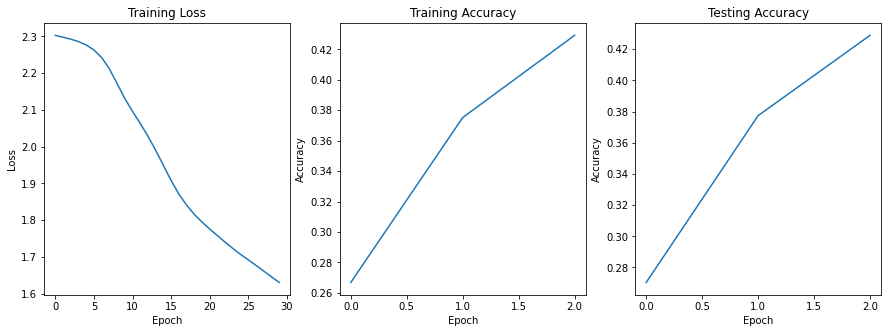

In [0]:
plot_results(train_losses_1024, train_accuracies_1024, test_accuracies_1024)

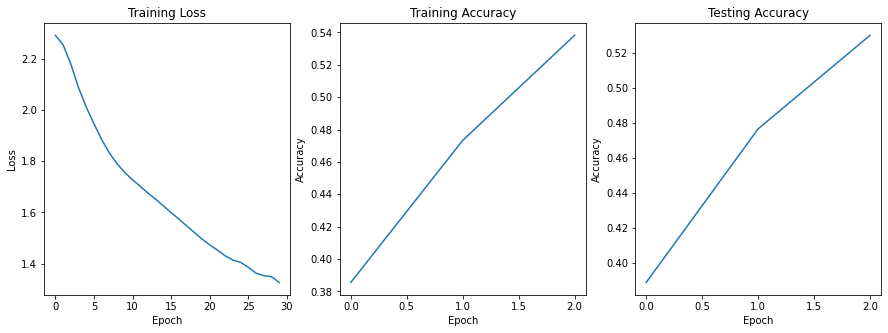

In [0]:
plot_results(train_losses_512, train_accuracies_512, test_accuracies_512)

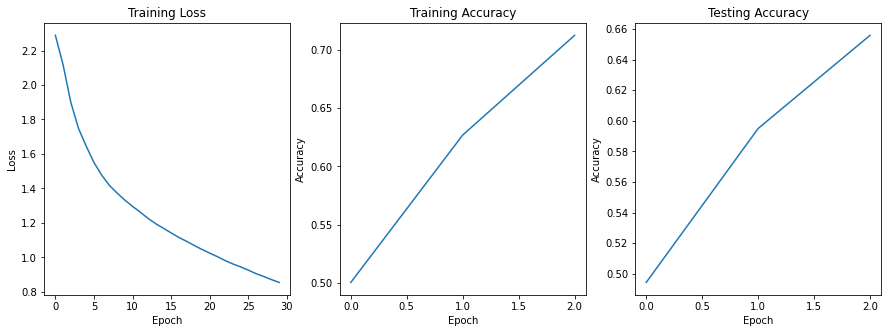

In [0]:
plot_results(train_losses_128, train_accuracies_128, test_accuracies_128)

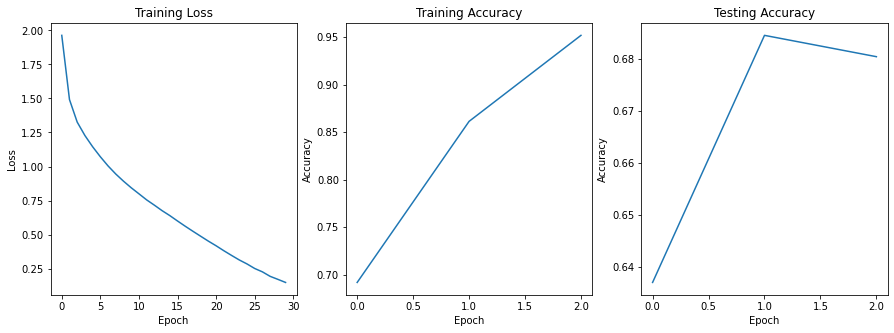

In [0]:
plot_results(train_losses_32, train_accuracies_32, test_accuracies_32)

###Answer

In a reasonable range, if we choose a larger batch size. We have lower iteraions time to finish an epoch. Faster training time for dealing with same data. Also, the more training examples used in the estimate, the more accurate this estimate will be and the more likely that the weights of the network will be adjusted in a way that will improve the performance of the model.

If we choose a smaller batch size, we have more iterations while choosing a smaller batch size. Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error. 

In this case, when choosing batch size to 32. The model overfit. Thus, in order to train a perfect model. we have to carefully choose our batch size.

### 2.3.2. How does learning rate work?

When you are trying to train a neural network it is really hard to choose a proper learning rate. 

Try to train your model with different learning rates and plot the training accuracy, test accuracy and loss and compare the training progress for learning rates = 10, 0.1, 0.01, 0.0001.

Analyze the results and choose the best one. Why did you choose this value?



In [0]:
# TODO: Your code here
net5 = CoolNet()
train_losses_10, train_accuracies_10, test_accuracies_10 = train_network(
    net5, 
    criterion=nn.CrossEntropyLoss(),
    lr=10, 
    epochs=30, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = nan



Epoch 1 summary -- loss = nan



Epoch 2 summary -- loss = nan



Epoch 3 summary -- loss = nan



Epoch 4 summary -- loss = nan



Epoch 5 summary -- loss = nan



Epoch 6 summary -- loss = nan



Epoch 7 summary -- loss = nan



Epoch 8 summary -- loss = nan



Epoch 9 summary -- loss = nan
Evaluating epoch 10



Train accuracy of the network: 10.00%
Train accuracy of plane = 100.00%
Hard negatives for plane
Train accuracy of car = 0.00%
Hard negatives for car
Train accuracy of bird = 0.00%
Hard negatives for bird
Train accuracy of cat = 0.00%
Hard negatives for cat
Train accuracy of deer = 0.00%
Hard negatives for deer
Train accuracy of dog = 0.00%
Hard negatives for dog
Train accuracy of frog = 0.00%
Hard negatives for frog
Train accuracy of horse = 0.00%
Hard negatives for horse
Train accuracy of ship = 0.00%
Hard negatives for ship
Train accuracy of truck = 0.00%
Hard negatives for truck



Test accuracy of the network: 10.00%
Test accuracy of plane = 100.00%
Hard negatives for plane
Test accuracy of car = 0.00%
Hard negatives for car
Test accuracy of bird = 0.00%
Hard negatives for bird
Test accuracy of cat = 0.00%
Hard negatives for cat
Test accuracy of deer = 0.00%
Hard negatives for deer
Test accuracy of dog = 0.00%
Hard negatives for dog
Test accuracy of frog = 0.00%
Hard negatives for frog
Test accuracy of horse = 0.00%
Hard negatives for horse
Test accuracy of ship = 0.00%
Hard negatives for ship
Test accuracy of truck = 0.00%
Hard negatives for truck



Epoch 10 summary -- loss = nan



Epoch 11 summary -- loss = nan



Epoch 12 summary -- loss = nan



Epoch 13 summary -- loss = nan



Epoch 14 summary -- loss = nan



Epoch 15 summary -- loss = nan



Epoch 16 summary -- loss = nan



Epoch 17 summary -- loss = nan



Epoch 18 summary -- loss = nan



Epoch 19 summary -- loss = nan
Evaluating epoch 20



Train accuracy of the network: 10.00%
Train accuracy of plane = 100.00%
Hard negatives for plane
Train accuracy of car = 0.00%
Hard negatives for car
Train accuracy of bird = 0.00%
Hard negatives for bird
Train accuracy of cat = 0.00%
Hard negatives for cat
Train accuracy of deer = 0.00%
Hard negatives for deer
Train accuracy of dog = 0.00%
Hard negatives for dog
Train accuracy of frog = 0.00%
Hard negatives for frog
Train accuracy of horse = 0.00%
Hard negatives for horse
Train accuracy of ship = 0.00%
Hard negatives for ship
Train accuracy of truck = 0.00%
Hard negatives for truck



Test accuracy of the network: 10.00%
Test accuracy of plane = 100.00%
Hard negatives for plane
Test accuracy of car = 0.00%
Hard negatives for car
Test accuracy of bird = 0.00%
Hard negatives for bird
Test accuracy of cat = 0.00%
Hard negatives for cat
Test accuracy of deer = 0.00%
Hard negatives for deer
Test accuracy of dog = 0.00%
Hard negatives for dog
Test accuracy of frog = 0.00%
Hard negatives for frog
Test accuracy of horse = 0.00%
Hard negatives for horse
Test accuracy of ship = 0.00%
Hard negatives for ship
Test accuracy of truck = 0.00%
Hard negatives for truck



Epoch 20 summary -- loss = nan



Epoch 21 summary -- loss = nan



Epoch 22 summary -- loss = nan



Epoch 23 summary -- loss = nan



Epoch 24 summary -- loss = nan



Epoch 25 summary -- loss = nan



Epoch 26 summary -- loss = nan



Epoch 27 summary -- loss = nan



Epoch 28 summary -- loss = nan



Epoch 29 summary -- loss = nan
Evaluating epoch 30



Train accuracy of the network: 10.00%
Train accuracy of plane = 100.00%
Hard negatives for plane
Train accuracy of car = 0.00%
Hard negatives for car
Train accuracy of bird = 0.00%
Hard negatives for bird
Train accuracy of cat = 0.00%
Hard negatives for cat
Train accuracy of deer = 0.00%
Hard negatives for deer
Train accuracy of dog = 0.00%
Hard negatives for dog
Train accuracy of frog = 0.00%
Hard negatives for frog
Train accuracy of horse = 0.00%
Hard negatives for horse
Train accuracy of ship = 0.00%
Hard negatives for ship
Train accuracy of truck = 0.00%
Hard negatives for truck



Test accuracy of the network: 10.00%
Test accuracy of plane = 100.00%
Hard negatives for plane
Test accuracy of car = 0.00%
Hard negatives for car
Test accuracy of bird = 0.00%
Hard negatives for bird
Test accuracy of cat = 0.00%
Hard negatives for cat
Test accuracy of deer = 0.00%
Hard negatives for deer
Test accuracy of dog = 0.00%
Hard negatives for dog
Test accuracy of frog = 0.00%
Hard negatives for frog
Test accuracy of horse = 0.00%
Hard negatives for horse
Test accuracy of ship = 0.00%
Hard negatives for ship
Test accuracy of truck = 0.00%
Hard negatives for truck


In [0]:
net6 = CoolNet()
train_losses_01, train_accuracies_01, test_accuracies_01 = train_network(
    net6, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.1, 
    epochs=30, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.229



Epoch 1 summary -- loss = 1.985



Epoch 2 summary -- loss = 1.840



Epoch 3 summary -- loss = 1.726



Epoch 4 summary -- loss = 1.647



Epoch 5 summary -- loss = 1.565



Epoch 6 summary -- loss = 1.510



Epoch 7 summary -- loss = 1.454



Epoch 8 summary -- loss = 1.404



Epoch 9 summary -- loss = 1.354
Evaluating epoch 10



Train accuracy of the network: 51.16%
Train accuracy of plane = 62.20%
Hard negatives for plane
Train accuracy of car = 73.64%
Hard negatives for car
Train accuracy of bird = 24.26%
Hard negatives for bird
Train accuracy of cat = 50.64%
Hard negatives for cat
Train accuracy of deer = 35.94%
Hard negatives for deer
Train accuracy of dog = 37.70%
Hard negatives for dog
Train accuracy of frog = 36.60%
Hard negatives for frog
Train accuracy of horse = 76.52%
Hard negatives for horse
Train accuracy of ship = 45.68%
Hard negatives for ship
Train accuracy of truck = 68.44%
Hard negatives for truck



Test accuracy of the network: 50.33%
Test accuracy of plane = 64.70%
Hard negatives for plane
Test accuracy of car = 73.60%
Hard negatives for car
Test accuracy of bird = 24.20%
Hard negatives for bird
Test accuracy of cat = 47.00%
Hard negatives for cat
Test accuracy of deer = 32.40%
Hard negatives for deer
Test accuracy of dog = 36.40%
Hard negatives for dog
Test accuracy of frog = 37.60%
Hard negatives for frog
Test accuracy of horse = 76.90%
Hard negatives for horse
Test accuracy of ship = 44.50%
Hard negatives for ship
Test accuracy of truck = 66.00%
Hard negatives for truck



Epoch 10 summary -- loss = 1.318



Epoch 11 summary -- loss = 1.301



Epoch 12 summary -- loss = 1.262



Epoch 13 summary -- loss = 1.216



Epoch 14 summary -- loss = 1.203



Epoch 15 summary -- loss = 1.182



Epoch 16 summary -- loss = 1.144



Epoch 17 summary -- loss = 1.128



Epoch 18 summary -- loss = 1.105



Epoch 19 summary -- loss = 1.089
Evaluating epoch 20



Train accuracy of the network: 64.21%
Train accuracy of plane = 70.24%
Hard negatives for plane
Train accuracy of car = 63.66%
Hard negatives for car
Train accuracy of bird = 40.46%
Hard negatives for bird
Train accuracy of cat = 53.64%
Hard negatives for cat
Train accuracy of deer = 53.78%
Hard negatives for deer
Train accuracy of dog = 61.24%
Hard negatives for dog
Train accuracy of frog = 73.06%
Hard negatives for frog
Train accuracy of horse = 65.82%
Hard negatives for horse
Train accuracy of ship = 75.46%
Hard negatives for ship
Train accuracy of truck = 84.74%
Hard negatives for truck



Test accuracy of the network: 60.74%
Test accuracy of plane = 67.20%
Hard negatives for plane
Test accuracy of car = 58.80%
Hard negatives for car
Test accuracy of bird = 37.20%
Hard negatives for bird
Test accuracy of cat = 47.10%
Hard negatives for cat
Test accuracy of deer = 48.30%
Hard negatives for deer
Test accuracy of dog = 58.10%
Hard negatives for dog
Test accuracy of frog = 74.30%
Hard negatives for frog
Test accuracy of horse = 62.80%
Hard negatives for horse
Test accuracy of ship = 73.30%
Hard negatives for ship
Test accuracy of truck = 80.30%
Hard negatives for truck



Epoch 20 summary -- loss = 1.058



Epoch 21 summary -- loss = 1.042



Epoch 22 summary -- loss = 1.016



Epoch 23 summary -- loss = 0.996



Epoch 24 summary -- loss = 0.991



Epoch 25 summary -- loss = 0.959



Epoch 26 summary -- loss = 0.942



Epoch 27 summary -- loss = 0.931



Epoch 28 summary -- loss = 0.910



Epoch 29 summary -- loss = 0.890
Evaluating epoch 30



Train accuracy of the network: 69.80%
Train accuracy of plane = 73.58%
Hard negatives for plane
Train accuracy of car = 85.10%
Hard negatives for car
Train accuracy of bird = 70.58%
Hard negatives for bird
Train accuracy of cat = 48.68%
Hard negatives for cat
Train accuracy of deer = 50.72%
Hard negatives for deer
Train accuracy of dog = 80.64%
Hard negatives for dog
Train accuracy of frog = 63.96%
Hard negatives for frog
Train accuracy of horse = 72.44%
Hard negatives for horse
Train accuracy of ship = 77.64%
Hard negatives for ship
Train accuracy of truck = 74.68%
Hard negatives for truck



Test accuracy of the network: 63.85%
Test accuracy of plane = 68.90%
Hard negatives for plane
Test accuracy of car = 80.50%
Hard negatives for car
Test accuracy of bird = 61.00%
Hard negatives for bird
Test accuracy of cat = 39.50%
Hard negatives for cat
Test accuracy of deer = 42.50%
Hard negatives for deer
Test accuracy of dog = 74.60%
Hard negatives for dog
Test accuracy of frog = 64.90%
Hard negatives for frog
Test accuracy of horse = 67.40%
Hard negatives for horse
Test accuracy of ship = 72.50%
Hard negatives for ship
Test accuracy of truck = 66.70%
Hard negatives for truck


In [0]:
net7 = CoolNet()
train_losses_0001, train_accuracies_0001, test_accuracies_0001 = train_network(
    net7, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.001, 
    epochs=30, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.302



Epoch 1 summary -- loss = 2.302



Epoch 2 summary -- loss = 2.301



Epoch 3 summary -- loss = 2.300



Epoch 4 summary -- loss = 2.299



Epoch 5 summary -- loss = 2.298



Epoch 6 summary -- loss = 2.298



Epoch 7 summary -- loss = 2.297



Epoch 8 summary -- loss = 2.296



Epoch 9 summary -- loss = 2.295
Evaluating epoch 10



Train accuracy of the network: 15.66%
Train accuracy of plane = 41.42%
Hard negatives for plane
Train accuracy of car = 0.02%
Hard negatives for car
Train accuracy of bird = 0.00%
Hard negatives for bird
Train accuracy of cat = 0.00%
Hard negatives for cat
Train accuracy of deer = 33.58%
Hard negatives for deer
Train accuracy of dog = 0.00%
Hard negatives for dog
Train accuracy of frog = 1.78%
Hard negatives for frog
Train accuracy of horse = 3.36%
Hard negatives for horse
Train accuracy of ship = 0.00%
Hard negatives for ship
Train accuracy of truck = 76.48%
Hard negatives for truck



Test accuracy of the network: 15.75%
Test accuracy of plane = 44.10%
Hard negatives for plane
Test accuracy of car = 0.00%
Hard negatives for car
Test accuracy of bird = 0.00%
Hard negatives for bird
Test accuracy of cat = 0.00%
Hard negatives for cat
Test accuracy of deer = 32.50%
Hard negatives for deer
Test accuracy of dog = 0.00%
Hard negatives for dog
Test accuracy of frog = 0.90%
Hard negatives for frog
Test accuracy of horse = 3.60%
Hard negatives for horse
Test accuracy of ship = 0.00%
Hard negatives for ship
Test accuracy of truck = 76.40%
Hard negatives for truck



Epoch 10 summary -- loss = 2.294



Epoch 11 summary -- loss = 2.293



Epoch 12 summary -- loss = 2.292



Epoch 13 summary -- loss = 2.292



Epoch 14 summary -- loss = 2.291



Epoch 15 summary -- loss = 2.290



Epoch 16 summary -- loss = 2.289



Epoch 17 summary -- loss = 2.288



Epoch 18 summary -- loss = 2.286



Epoch 19 summary -- loss = 2.285
Evaluating epoch 20



Train accuracy of the network: 17.26%
Train accuracy of plane = 49.46%
Hard negatives for plane
Train accuracy of car = 0.44%
Hard negatives for car
Train accuracy of bird = 0.00%
Hard negatives for bird
Train accuracy of cat = 0.00%
Hard negatives for cat
Train accuracy of deer = 33.90%
Hard negatives for deer
Train accuracy of dog = 0.02%
Hard negatives for dog
Train accuracy of frog = 3.10%
Hard negatives for frog
Train accuracy of horse = 2.86%
Hard negatives for horse
Train accuracy of ship = 0.14%
Hard negatives for ship
Train accuracy of truck = 82.70%
Hard negatives for truck



Test accuracy of the network: 17.50%
Test accuracy of plane = 54.30%
Hard negatives for plane
Test accuracy of car = 0.70%
Hard negatives for car
Test accuracy of bird = 0.00%
Hard negatives for bird
Test accuracy of cat = 0.00%
Hard negatives for cat
Test accuracy of deer = 33.40%
Hard negatives for deer
Test accuracy of dog = 0.00%
Hard negatives for dog
Test accuracy of frog = 1.60%
Hard negatives for frog
Test accuracy of horse = 2.70%
Hard negatives for horse
Test accuracy of ship = 0.00%
Hard negatives for ship
Test accuracy of truck = 82.30%
Hard negatives for truck



Epoch 20 summary -- loss = 2.284



Epoch 21 summary -- loss = 2.283



Epoch 22 summary -- loss = 2.282



Epoch 23 summary -- loss = 2.280



Epoch 24 summary -- loss = 2.279



Epoch 25 summary -- loss = 2.277



Epoch 26 summary -- loss = 2.276



Epoch 27 summary -- loss = 2.274



Epoch 28 summary -- loss = 2.273



Epoch 29 summary -- loss = 2.271
Evaluating epoch 30



Train accuracy of the network: 18.99%
Train accuracy of plane = 55.54%
Hard negatives for plane
Train accuracy of car = 3.82%
Hard negatives for car
Train accuracy of bird = 0.00%
Hard negatives for bird
Train accuracy of cat = 0.04%
Hard negatives for cat
Train accuracy of deer = 37.58%
Hard negatives for deer
Train accuracy of dog = 1.16%
Hard negatives for dog
Train accuracy of frog = 9.34%
Hard negatives for frog
Train accuracy of horse = 2.48%
Hard negatives for horse
Train accuracy of ship = 1.04%
Hard negatives for ship
Train accuracy of truck = 78.90%
Hard negatives for truck



Test accuracy of the network: 19.02%
Test accuracy of plane = 59.80%
Hard negatives for plane
Test accuracy of car = 3.30%
Hard negatives for car
Test accuracy of bird = 0.00%
Hard negatives for bird
Test accuracy of cat = 0.00%
Hard negatives for cat
Test accuracy of deer = 35.40%
Hard negatives for deer
Test accuracy of dog = 1.80%
Hard negatives for dog
Test accuracy of frog = 8.50%
Hard negatives for frog
Test accuracy of horse = 2.20%
Hard negatives for horse
Test accuracy of ship = 0.80%
Hard negatives for ship
Test accuracy of truck = 78.40%
Hard negatives for truck


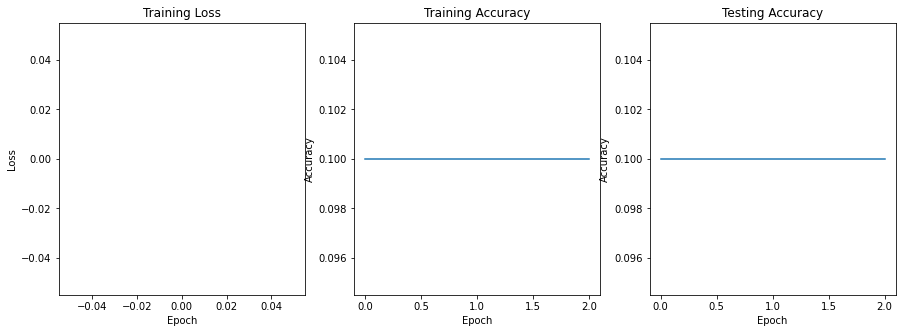

In [0]:
plot_results(train_losses_10, train_accuracies_10, test_accuracies_10)

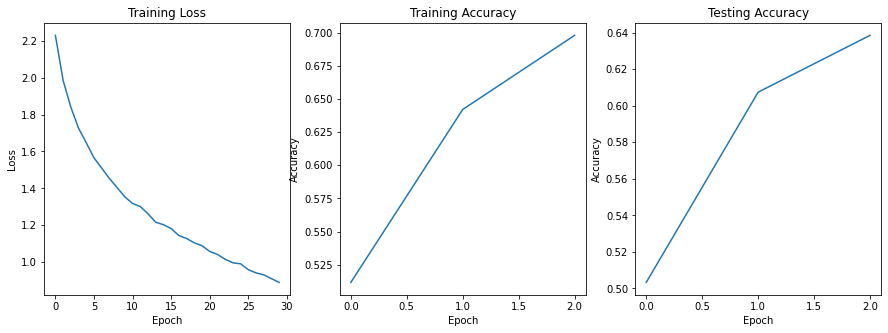

In [0]:
plot_results(train_losses_01, train_accuracies_01, test_accuracies_01)

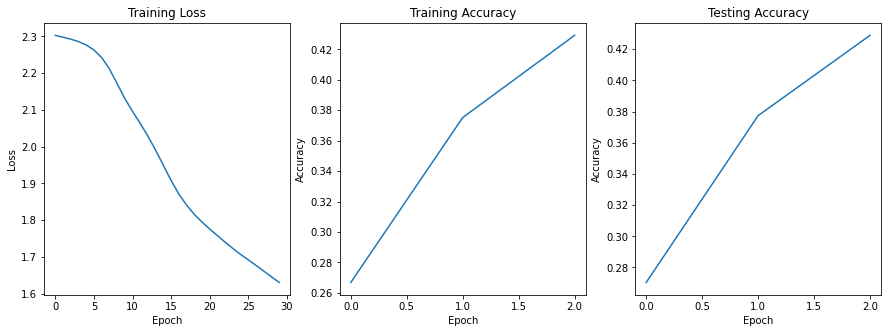

In [0]:
#001
plot_results(train_losses_1024, train_accuracies_1024, test_accuracies_1024)

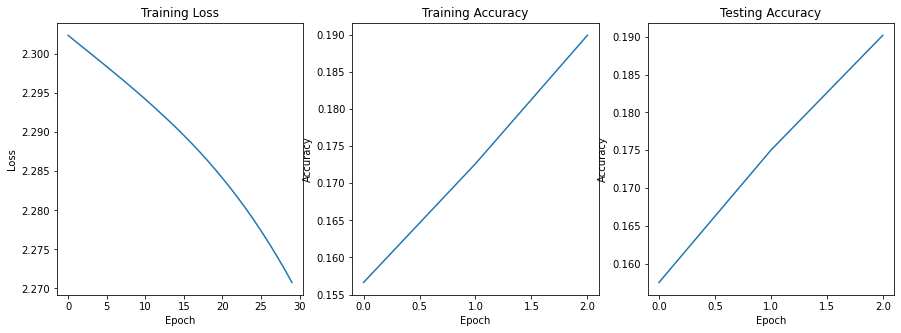

In [0]:
plot_results(train_losses_0001, train_accuracies_0001, test_accuracies_0001)

**Question**:
Analyze the results and choose one value to use. Why did you choose this value?

###Answer
I will choose learning rate to 0.1 in this case.

If learning rate is too small, gradient descent can be slow. The networking is not learning.

If learning is too large, gradient descent can overshoot the minimum. It may fail to converge, or even diverge.

### 2.3.3. Learning rate scheduling
During training it is often useful to reduce learning rate as the training progresses.

Fill in `set_learning_rate` below to scale the learning rate by 0.1 (reduce by 90%) every 30 epochs and observe the behavior of network for 90 epochs. 


In [0]:
def set_learning_rate(optimizer, epoch, base_lr):
    # TODO: adjust learning rate here
    lr = base_lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:  
        param_group['lr'] = lr

In [0]:
net = CoolNet()
train_losses_lr, train_accuracies_lr, test_accuracies_lr = train_network(
    net, 
    lr_func=set_learning_rate,
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=90, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.299



Epoch 1 summary -- loss = 2.291



Epoch 2 summary -- loss = 2.281



Epoch 3 summary -- loss = 2.268



Epoch 4 summary -- loss = 2.249



Epoch 5 summary -- loss = 2.224



Epoch 6 summary -- loss = 2.194



Epoch 7 summary -- loss = 2.157



Epoch 8 summary -- loss = 2.117



Epoch 9 summary -- loss = 2.077
Evaluating epoch 10



Train accuracy of the network: 26.80%
Train accuracy of plane = 40.36%
Hard negatives for plane
Train accuracy of car = 18.70%
Hard negatives for car
Train accuracy of bird = 0.34%
Hard negatives for bird
Train accuracy of cat = 11.78%
Hard negatives for cat
Train accuracy of deer = 0.46%
Hard negatives for deer
Train accuracy of dog = 42.44%
Hard negatives for dog
Train accuracy of frog = 57.32%
Hard negatives for frog
Train accuracy of horse = 6.30%
Hard negatives for horse
Train accuracy of ship = 38.56%
Hard negatives for ship
Train accuracy of truck = 51.72%
Hard negatives for truck



Test accuracy of the network: 27.71%
Test accuracy of plane = 43.80%
Hard negatives for plane
Test accuracy of car = 20.50%
Hard negatives for car
Test accuracy of bird = 0.10%
Hard negatives for bird
Test accuracy of cat = 11.80%
Hard negatives for cat
Test accuracy of deer = 0.50%
Hard negatives for deer
Test accuracy of dog = 42.40%
Hard negatives for dog
Test accuracy of frog = 57.50%
Hard negatives for frog
Test accuracy of horse = 7.10%
Hard negatives for horse
Test accuracy of ship = 41.50%
Hard negatives for ship
Test accuracy of truck = 51.90%
Hard negatives for truck



Epoch 10 summary -- loss = 2.041



Epoch 11 summary -- loss = 2.007



Epoch 12 summary -- loss = 1.975



Epoch 13 summary -- loss = 1.945



Epoch 14 summary -- loss = 1.918



Epoch 15 summary -- loss = 1.893



Epoch 16 summary -- loss = 1.869



Epoch 17 summary -- loss = 1.847



Epoch 18 summary -- loss = 1.825



Epoch 19 summary -- loss = 1.805
Evaluating epoch 20



Train accuracy of the network: 36.63%
Train accuracy of plane = 43.18%
Hard negatives for plane
Train accuracy of car = 38.76%
Hard negatives for car
Train accuracy of bird = 7.16%
Hard negatives for bird
Train accuracy of cat = 18.66%
Hard negatives for cat
Train accuracy of deer = 16.64%
Hard negatives for deer
Train accuracy of dog = 42.26%
Hard negatives for dog
Train accuracy of frog = 58.82%
Hard negatives for frog
Train accuracy of horse = 42.22%
Hard negatives for horse
Train accuracy of ship = 45.78%
Hard negatives for ship
Train accuracy of truck = 52.84%
Hard negatives for truck



Test accuracy of the network: 37.26%
Test accuracy of plane = 45.30%
Hard negatives for plane
Test accuracy of car = 39.80%
Hard negatives for car
Test accuracy of bird = 7.00%
Hard negatives for bird
Test accuracy of cat = 18.10%
Hard negatives for cat
Test accuracy of deer = 17.30%
Hard negatives for deer
Test accuracy of dog = 43.60%
Hard negatives for dog
Test accuracy of frog = 60.70%
Hard negatives for frog
Test accuracy of horse = 43.10%
Hard negatives for horse
Test accuracy of ship = 46.60%
Hard negatives for ship
Test accuracy of truck = 51.10%
Hard negatives for truck



Epoch 20 summary -- loss = 1.786



Epoch 21 summary -- loss = 1.767



Epoch 22 summary -- loss = 1.749



Epoch 23 summary -- loss = 1.732



Epoch 24 summary -- loss = 1.715



Epoch 25 summary -- loss = 1.699



Epoch 26 summary -- loss = 1.682



Epoch 27 summary -- loss = 1.666



Epoch 28 summary -- loss = 1.650



Epoch 29 summary -- loss = 1.633
Evaluating epoch 30



Train accuracy of the network: 43.22%
Train accuracy of plane = 47.96%
Hard negatives for plane
Train accuracy of car = 47.74%
Hard negatives for car
Train accuracy of bird = 24.94%
Hard negatives for bird
Train accuracy of cat = 25.66%
Hard negatives for cat
Train accuracy of deer = 31.14%
Hard negatives for deer
Train accuracy of dog = 40.04%
Hard negatives for dog
Train accuracy of frog = 58.58%
Hard negatives for frog
Train accuracy of horse = 46.20%
Hard negatives for horse
Train accuracy of ship = 55.30%
Hard negatives for ship
Train accuracy of truck = 54.66%
Hard negatives for truck



Test accuracy of the network: 43.36%
Test accuracy of plane = 49.60%
Hard negatives for plane
Test accuracy of car = 47.80%
Hard negatives for car
Test accuracy of bird = 24.00%
Hard negatives for bird
Test accuracy of cat = 24.20%
Hard negatives for cat
Test accuracy of deer = 30.50%
Hard negatives for deer
Test accuracy of dog = 40.70%
Hard negatives for dog
Test accuracy of frog = 61.30%
Hard negatives for frog
Test accuracy of horse = 46.70%
Hard negatives for horse
Test accuracy of ship = 54.90%
Hard negatives for ship
Test accuracy of truck = 53.90%
Hard negatives for truck



Epoch 30 summary -- loss = 1.621



Epoch 31 summary -- loss = 1.619



Epoch 32 summary -- loss = 1.618



Epoch 33 summary -- loss = 1.616



Epoch 34 summary -- loss = 1.614



Epoch 35 summary -- loss = 1.613



Epoch 36 summary -- loss = 1.611



Epoch 37 summary -- loss = 1.609



Epoch 38 summary -- loss = 1.608



Epoch 39 summary -- loss = 1.606
Evaluating epoch 40



Train accuracy of the network: 43.80%
Train accuracy of plane = 48.22%
Hard negatives for plane
Train accuracy of car = 51.54%
Hard negatives for car
Train accuracy of bird = 24.24%
Hard negatives for bird
Train accuracy of cat = 24.58%
Hard negatives for cat
Train accuracy of deer = 32.28%
Hard negatives for deer
Train accuracy of dog = 39.58%
Hard negatives for dog
Train accuracy of frog = 59.64%
Hard negatives for frog
Train accuracy of horse = 49.36%
Hard negatives for horse
Train accuracy of ship = 55.94%
Hard negatives for ship
Train accuracy of truck = 52.58%
Hard negatives for truck



Test accuracy of the network: 43.78%
Test accuracy of plane = 49.70%
Hard negatives for plane
Test accuracy of car = 50.70%
Hard negatives for car
Test accuracy of bird = 23.40%
Hard negatives for bird
Test accuracy of cat = 22.90%
Hard negatives for cat
Test accuracy of deer = 31.50%
Hard negatives for deer
Test accuracy of dog = 40.00%
Hard negatives for dog
Test accuracy of frog = 62.80%
Hard negatives for frog
Test accuracy of horse = 49.40%
Hard negatives for horse
Test accuracy of ship = 56.30%
Hard negatives for ship
Test accuracy of truck = 51.10%
Hard negatives for truck



Epoch 40 summary -- loss = 1.604



Epoch 41 summary -- loss = 1.603



Epoch 42 summary -- loss = 1.601



Epoch 43 summary -- loss = 1.599



Epoch 44 summary -- loss = 1.598



Epoch 45 summary -- loss = 1.596



Epoch 46 summary -- loss = 1.594



Epoch 47 summary -- loss = 1.592



Epoch 48 summary -- loss = 1.591



Epoch 49 summary -- loss = 1.589
Evaluating epoch 50



Train accuracy of the network: 44.35%
Train accuracy of plane = 48.80%
Hard negatives for plane
Train accuracy of car = 52.92%
Hard negatives for car
Train accuracy of bird = 26.14%
Hard negatives for bird
Train accuracy of cat = 25.82%
Hard negatives for cat
Train accuracy of deer = 32.72%
Hard negatives for deer
Train accuracy of dog = 39.16%
Hard negatives for dog
Train accuracy of frog = 59.52%
Hard negatives for frog
Train accuracy of horse = 49.94%
Hard negatives for horse
Train accuracy of ship = 55.88%
Hard negatives for ship
Train accuracy of truck = 52.62%
Hard negatives for truck



Test accuracy of the network: 44.42%
Test accuracy of plane = 49.90%
Hard negatives for plane
Test accuracy of car = 52.60%
Hard negatives for car
Test accuracy of bird = 25.30%
Hard negatives for bird
Test accuracy of cat = 24.40%
Hard negatives for cat
Test accuracy of deer = 32.10%
Hard negatives for deer
Test accuracy of dog = 39.10%
Hard negatives for dog
Test accuracy of frog = 63.00%
Hard negatives for frog
Test accuracy of horse = 50.20%
Hard negatives for horse
Test accuracy of ship = 56.60%
Hard negatives for ship
Test accuracy of truck = 51.00%
Hard negatives for truck



Epoch 50 summary -- loss = 1.588



Epoch 51 summary -- loss = 1.586



Epoch 52 summary -- loss = 1.585



Epoch 53 summary -- loss = 1.583



Epoch 54 summary -- loss = 1.581



Epoch 55 summary -- loss = 1.580



Epoch 56 summary -- loss = 1.578



Epoch 57 summary -- loss = 1.576



Epoch 58 summary -- loss = 1.575



Epoch 59 summary -- loss = 1.573
Evaluating epoch 60



Train accuracy of the network: 44.81%
Train accuracy of plane = 48.64%
Hard negatives for plane
Train accuracy of car = 52.86%
Hard negatives for car
Train accuracy of bird = 26.46%
Hard negatives for bird
Train accuracy of cat = 26.32%
Hard negatives for cat
Train accuracy of deer = 33.46%
Hard negatives for deer
Train accuracy of dog = 39.64%
Hard negatives for dog
Train accuracy of frog = 59.74%
Hard negatives for frog
Train accuracy of horse = 50.30%
Hard negatives for horse
Train accuracy of ship = 58.16%
Hard negatives for ship
Train accuracy of truck = 52.54%
Hard negatives for truck



Test accuracy of the network: 44.94%
Test accuracy of plane = 49.70%
Hard negatives for plane
Test accuracy of car = 52.40%
Hard negatives for car
Test accuracy of bird = 26.20%
Hard negatives for bird
Test accuracy of cat = 24.80%
Hard negatives for cat
Test accuracy of deer = 33.10%
Hard negatives for deer
Test accuracy of dog = 39.30%
Hard negatives for dog
Test accuracy of frog = 63.20%
Hard negatives for frog
Test accuracy of horse = 50.70%
Hard negatives for horse
Test accuracy of ship = 58.70%
Hard negatives for ship
Test accuracy of truck = 51.30%
Hard negatives for truck



Epoch 60 summary -- loss = 1.572



Epoch 61 summary -- loss = 1.572



Epoch 62 summary -- loss = 1.572



Epoch 63 summary -- loss = 1.571



Epoch 64 summary -- loss = 1.571



Epoch 65 summary -- loss = 1.571



Epoch 66 summary -- loss = 1.571



Epoch 67 summary -- loss = 1.571



Epoch 68 summary -- loss = 1.570



Epoch 69 summary -- loss = 1.571
Evaluating epoch 70



Train accuracy of the network: 44.88%
Train accuracy of plane = 49.16%
Hard negatives for plane
Train accuracy of car = 53.36%
Hard negatives for car
Train accuracy of bird = 26.46%
Hard negatives for bird
Train accuracy of cat = 26.10%
Hard negatives for cat
Train accuracy of deer = 33.52%
Hard negatives for deer
Train accuracy of dog = 39.72%
Hard negatives for dog
Train accuracy of frog = 59.80%
Hard negatives for frog
Train accuracy of horse = 50.34%
Hard negatives for horse
Train accuracy of ship = 57.26%
Hard negatives for ship
Train accuracy of truck = 53.12%
Hard negatives for truck



Test accuracy of the network: 45.03%
Test accuracy of plane = 50.10%
Hard negatives for plane
Test accuracy of car = 53.10%
Hard negatives for car
Test accuracy of bird = 26.60%
Hard negatives for bird
Test accuracy of cat = 24.30%
Hard negatives for cat
Test accuracy of deer = 33.40%
Hard negatives for deer
Test accuracy of dog = 39.30%
Hard negatives for dog
Test accuracy of frog = 63.20%
Hard negatives for frog
Test accuracy of horse = 50.60%
Hard negatives for horse
Test accuracy of ship = 58.00%
Hard negatives for ship
Test accuracy of truck = 51.70%
Hard negatives for truck



Epoch 70 summary -- loss = 1.570



Epoch 71 summary -- loss = 1.570



Epoch 72 summary -- loss = 1.570



Epoch 73 summary -- loss = 1.570



Epoch 74 summary -- loss = 1.569



Epoch 75 summary -- loss = 1.569



Epoch 76 summary -- loss = 1.569



Epoch 77 summary -- loss = 1.569



Epoch 78 summary -- loss = 1.569



Epoch 79 summary -- loss = 1.569
Evaluating epoch 80



Train accuracy of the network: 44.94%
Train accuracy of plane = 49.20%
Hard negatives for plane
Train accuracy of car = 53.34%
Hard negatives for car
Train accuracy of bird = 26.48%
Hard negatives for bird
Train accuracy of cat = 26.16%
Hard negatives for cat
Train accuracy of deer = 33.72%
Hard negatives for deer
Train accuracy of dog = 39.66%
Hard negatives for dog
Train accuracy of frog = 59.80%
Hard negatives for frog
Train accuracy of horse = 50.36%
Hard negatives for horse
Train accuracy of ship = 57.42%
Hard negatives for ship
Train accuracy of truck = 53.28%
Hard negatives for truck



Test accuracy of the network: 45.06%
Test accuracy of plane = 50.10%
Hard negatives for plane
Test accuracy of car = 53.10%
Hard negatives for car
Test accuracy of bird = 26.60%
Hard negatives for bird
Test accuracy of cat = 24.40%
Hard negatives for cat
Test accuracy of deer = 33.40%
Hard negatives for deer
Test accuracy of dog = 39.30%
Hard negatives for dog
Test accuracy of frog = 63.20%
Hard negatives for frog
Test accuracy of horse = 50.50%
Hard negatives for horse
Test accuracy of ship = 58.00%
Hard negatives for ship
Test accuracy of truck = 52.00%
Hard negatives for truck



Epoch 80 summary -- loss = 1.569



Epoch 81 summary -- loss = 1.568



Epoch 82 summary -- loss = 1.568



Epoch 83 summary -- loss = 1.568



Epoch 84 summary -- loss = 1.568



Epoch 85 summary -- loss = 1.568



Epoch 86 summary -- loss = 1.568



Epoch 87 summary -- loss = 1.567



Epoch 88 summary -- loss = 1.567



Epoch 89 summary -- loss = 1.567
Evaluating epoch 90



Train accuracy of the network: 45.01%
Train accuracy of plane = 49.34%
Hard negatives for plane
Train accuracy of car = 53.42%
Hard negatives for car
Train accuracy of bird = 26.62%
Hard negatives for bird
Train accuracy of cat = 26.28%
Hard negatives for cat
Train accuracy of deer = 33.86%
Hard negatives for deer
Train accuracy of dog = 39.66%
Hard negatives for dog
Train accuracy of frog = 59.82%
Hard negatives for frog
Train accuracy of horse = 50.48%
Hard negatives for horse
Train accuracy of ship = 57.36%
Hard negatives for ship
Train accuracy of truck = 53.30%
Hard negatives for truck



Test accuracy of the network: 45.08%
Test accuracy of plane = 50.20%
Hard negatives for plane
Test accuracy of car = 53.20%
Hard negatives for car
Test accuracy of bird = 26.50%
Hard negatives for bird
Test accuracy of cat = 24.30%
Hard negatives for cat
Test accuracy of deer = 33.50%
Hard negatives for deer
Test accuracy of dog = 39.30%
Hard negatives for dog
Test accuracy of frog = 63.20%
Hard negatives for frog
Test accuracy of horse = 50.60%
Hard negatives for horse
Test accuracy of ship = 58.00%
Hard negatives for ship
Test accuracy of truck = 52.00%
Hard negatives for truck


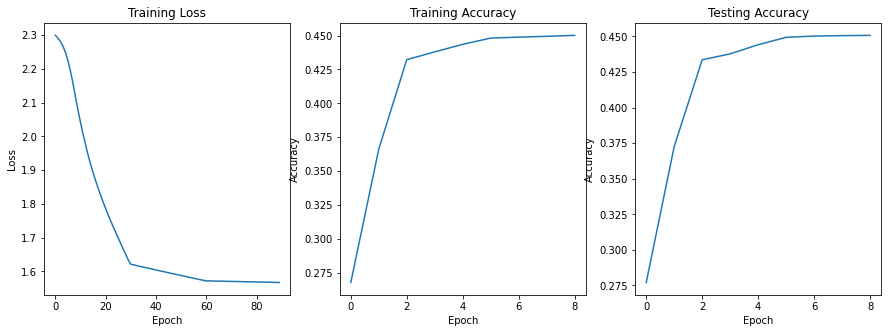

In [0]:
plot_results(train_losses_lr, train_accuracies_lr, test_accuracies_lr)

**Question**: 
What do you observe? Why do you think it is useful to decrease the learning rate over time?

###Answer
A small learning rate is cautious. It makes the network adjust slowly and carefully. Easy to overfitting and slow convergence speed.

A large learning rate is impetuous. It adjusts quickly but might be overshooting. Larger noise and prompt to explode the loss.

It is useful to decrease the learning rate over time. The jump back to high learning rates helps to avoid local optima. High learning rates are faster in crossing flat areas of the loss function. So we choose a larger learning rate at the begining to increase the convergence speed. Then decrease the learning rate with later iterations to fine tune the weights.

### 2.3.4. Data Augmentation

Most of the popular computer vision datasets have tens of thousands of images. 

Cifar-10 is a dataset of 60000 32x32 colour images in 10 classes, which can be relatively small in compare to ImageNet which has 1M images. 

The more the number of parameters is, the more likely our model is to overfit to the small dataset. 
As you might have already faced this issue while training the CoolNet, after some iterations the training accuracy reaches its maximum (saturates) while the test accuracy is still relatively low. 

To solve this problem, we use the data augmentation to help the network avoid overfitting.

Add data transformations in to the class below and compare the results. You are free to use any type and any number of data augmentation techniques.

Just be aware that data augmentation should just happen during training phase. 

In [0]:
import PIL
train_transform = transforms.Compose([
    # TODO: Add data augmentations here
    # You can find a list of transforms here:
    #  https://pytorch.org/docs/stable/torchvision/transforms.html
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Normalize rescales and shifts the data so that it has a zero mean 
    # and unit variance. This reduces bias and makes it easier to learn!
    # The values here are the mean and variance of our inputs.
    # This will change the input images to be centered at 0 and be 
    # between -1 and 1.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [0]:
net_data_aug = CoolNet()
train_losses_data_aug, train_accuracies_data_aug, test_accuracies_data_aug = train_network(
    net_data_aug, 
    criterion=nn.CrossEntropyLoss(),
    train_transform=train_transform,
    lr=0.1, 
    epochs=60, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.254



Epoch 1 summary -- loss = 2.009



Epoch 2 summary -- loss = 1.861



Epoch 3 summary -- loss = 1.767



Epoch 4 summary -- loss = 1.715



Epoch 5 summary -- loss = 1.643



Epoch 6 summary -- loss = 1.598



Epoch 7 summary -- loss = 1.560



Epoch 8 summary -- loss = 1.512



Epoch 9 summary -- loss = 1.490
Evaluating epoch 10



Train accuracy of the network: 49.20%
Train accuracy of plane = 54.68%
Hard negatives for plane
Train accuracy of car = 61.36%
Hard negatives for car
Train accuracy of bird = 26.58%
Hard negatives for bird
Train accuracy of cat = 28.66%
Hard negatives for cat
Train accuracy of deer = 40.78%
Hard negatives for deer
Train accuracy of dog = 42.20%
Hard negatives for dog
Train accuracy of frog = 68.44%
Hard negatives for frog
Train accuracy of horse = 57.36%
Hard negatives for horse
Train accuracy of ship = 63.34%
Hard negatives for ship
Train accuracy of truck = 50.00%
Hard negatives for truck



Test accuracy of the network: 50.47%
Test accuracy of plane = 56.30%
Hard negatives for plane
Test accuracy of car = 68.00%
Hard negatives for car
Test accuracy of bird = 25.50%
Hard negatives for bird
Test accuracy of cat = 19.10%
Hard negatives for cat
Test accuracy of deer = 31.70%
Hard negatives for deer
Test accuracy of dog = 45.50%
Hard negatives for dog
Test accuracy of frog = 76.50%
Hard negatives for frog
Test accuracy of horse = 64.60%
Hard negatives for horse
Test accuracy of ship = 60.90%
Hard negatives for ship
Test accuracy of truck = 56.60%
Hard negatives for truck



Epoch 10 summary -- loss = 1.466



Epoch 11 summary -- loss = 1.431



Epoch 12 summary -- loss = 1.412



Epoch 13 summary -- loss = 1.382



Epoch 14 summary -- loss = 1.357



Epoch 15 summary -- loss = 1.338



Epoch 16 summary -- loss = 1.320



Epoch 17 summary -- loss = 1.305



Epoch 18 summary -- loss = 1.294



Epoch 19 summary -- loss = 1.267
Evaluating epoch 20



Train accuracy of the network: 56.10%
Train accuracy of plane = 53.80%
Hard negatives for plane
Train accuracy of car = 69.72%
Hard negatives for car
Train accuracy of bird = 50.96%
Hard negatives for bird
Train accuracy of cat = 45.36%
Hard negatives for cat
Train accuracy of deer = 38.96%
Hard negatives for deer
Train accuracy of dog = 60.40%
Hard negatives for dog
Train accuracy of frog = 52.94%
Hard negatives for frog
Train accuracy of horse = 50.04%
Hard negatives for horse
Train accuracy of ship = 80.26%
Hard negatives for ship
Train accuracy of truck = 58.38%
Hard negatives for truck



Test accuracy of the network: 58.48%
Test accuracy of plane = 58.10%
Hard negatives for plane
Test accuracy of car = 77.00%
Hard negatives for car
Test accuracy of bird = 45.90%
Hard negatives for bird
Test accuracy of cat = 43.00%
Hard negatives for cat
Test accuracy of deer = 36.90%
Hard negatives for deer
Test accuracy of dog = 62.50%
Hard negatives for dog
Test accuracy of frog = 63.00%
Hard negatives for frog
Test accuracy of horse = 59.50%
Hard negatives for horse
Test accuracy of ship = 77.00%
Hard negatives for ship
Test accuracy of truck = 61.90%
Hard negatives for truck



Epoch 20 summary -- loss = 1.246



Epoch 21 summary -- loss = 1.241



Epoch 22 summary -- loss = 1.228



Epoch 23 summary -- loss = 1.212



Epoch 24 summary -- loss = 1.201



Epoch 25 summary -- loss = 1.172



Epoch 26 summary -- loss = 1.173



Epoch 27 summary -- loss = 1.158



Epoch 28 summary -- loss = 1.157



Epoch 29 summary -- loss = 1.131
Evaluating epoch 30



Train accuracy of the network: 61.28%
Train accuracy of plane = 69.66%
Hard negatives for plane
Train accuracy of car = 83.52%
Hard negatives for car
Train accuracy of bird = 37.90%
Hard negatives for bird
Train accuracy of cat = 51.02%
Hard negatives for cat
Train accuracy of deer = 52.20%
Hard negatives for deer
Train accuracy of dog = 43.48%
Hard negatives for dog
Train accuracy of frog = 77.82%
Hard negatives for frog
Train accuracy of horse = 62.42%
Hard negatives for horse
Train accuracy of ship = 68.18%
Hard negatives for ship
Train accuracy of truck = 66.28%
Hard negatives for truck



Test accuracy of the network: 60.99%
Test accuracy of plane = 72.50%
Hard negatives for plane
Test accuracy of car = 86.10%
Hard negatives for car
Test accuracy of bird = 38.00%
Hard negatives for bird
Test accuracy of cat = 44.30%
Hard negatives for cat
Test accuracy of deer = 43.70%
Hard negatives for deer
Test accuracy of dog = 46.80%
Hard negatives for dog
Test accuracy of frog = 81.30%
Hard negatives for frog
Test accuracy of horse = 68.00%
Hard negatives for horse
Test accuracy of ship = 63.80%
Hard negatives for ship
Test accuracy of truck = 65.40%
Hard negatives for truck



Epoch 30 summary -- loss = 1.132



Epoch 31 summary -- loss = 1.117



Epoch 32 summary -- loss = 1.105



Epoch 33 summary -- loss = 1.092



Epoch 34 summary -- loss = 1.091



Epoch 35 summary -- loss = 1.075



Epoch 36 summary -- loss = 1.071



Epoch 37 summary -- loss = 1.047



Epoch 38 summary -- loss = 1.047



Epoch 39 summary -- loss = 1.039
Evaluating epoch 40



Train accuracy of the network: 63.16%
Train accuracy of plane = 77.34%
Hard negatives for plane
Train accuracy of car = 66.08%
Hard negatives for car
Train accuracy of bird = 47.34%
Hard negatives for bird
Train accuracy of cat = 37.72%
Hard negatives for cat
Train accuracy of deer = 51.78%
Hard negatives for deer
Train accuracy of dog = 56.22%
Hard negatives for dog
Train accuracy of frog = 78.26%
Hard negatives for frog
Train accuracy of horse = 73.90%
Hard negatives for horse
Train accuracy of ship = 57.16%
Hard negatives for ship
Train accuracy of truck = 86.28%
Hard negatives for truck



Test accuracy of the network: 62.26%
Test accuracy of plane = 78.70%
Hard negatives for plane
Test accuracy of car = 67.00%
Hard negatives for car
Test accuracy of bird = 42.10%
Hard negatives for bird
Test accuracy of cat = 34.80%
Hard negatives for cat
Test accuracy of deer = 48.10%
Hard negatives for deer
Test accuracy of dog = 57.20%
Hard negatives for dog
Test accuracy of frog = 81.10%
Hard negatives for frog
Test accuracy of horse = 74.00%
Hard negatives for horse
Test accuracy of ship = 52.50%
Hard negatives for ship
Test accuracy of truck = 87.10%
Hard negatives for truck



Epoch 40 summary -- loss = 1.020



Epoch 41 summary -- loss = 1.020



Epoch 42 summary -- loss = 1.016



Epoch 43 summary -- loss = 1.003



Epoch 44 summary -- loss = 0.998



Epoch 45 summary -- loss = 0.986



Epoch 46 summary -- loss = 0.985



Epoch 47 summary -- loss = 0.970



Epoch 48 summary -- loss = 0.971



Epoch 49 summary -- loss = 0.955
Evaluating epoch 50



Train accuracy of the network: 66.70%
Train accuracy of plane = 68.00%
Hard negatives for plane
Train accuracy of car = 73.82%
Hard negatives for car
Train accuracy of bird = 43.12%
Hard negatives for bird
Train accuracy of cat = 56.52%
Hard negatives for cat
Train accuracy of deer = 73.34%
Hard negatives for deer
Train accuracy of dog = 41.52%
Hard negatives for dog
Train accuracy of frog = 80.32%
Hard negatives for frog
Train accuracy of horse = 72.84%
Hard negatives for horse
Train accuracy of ship = 73.42%
Hard negatives for ship
Train accuracy of truck = 82.32%
Hard negatives for truck



Test accuracy of the network: 65.69%
Test accuracy of plane = 70.30%
Hard negatives for plane
Test accuracy of car = 74.10%
Hard negatives for car
Test accuracy of bird = 42.00%
Hard negatives for bird
Test accuracy of cat = 47.30%
Hard negatives for cat
Test accuracy of deer = 66.60%
Hard negatives for deer
Test accuracy of dog = 45.50%
Hard negatives for dog
Test accuracy of frog = 83.40%
Hard negatives for frog
Test accuracy of horse = 74.40%
Hard negatives for horse
Test accuracy of ship = 69.90%
Hard negatives for ship
Test accuracy of truck = 83.40%
Hard negatives for truck



Epoch 50 summary -- loss = 0.954



Epoch 51 summary -- loss = 0.946



Epoch 52 summary -- loss = 0.929



Epoch 53 summary -- loss = 0.936



Epoch 54 summary -- loss = 0.935



Epoch 55 summary -- loss = 0.914



Epoch 56 summary -- loss = 0.912



Epoch 57 summary -- loss = 0.914



Epoch 58 summary -- loss = 0.896



Epoch 59 summary -- loss = 0.889
Evaluating epoch 60



Train accuracy of the network: 69.66%
Train accuracy of plane = 63.16%
Hard negatives for plane
Train accuracy of car = 83.10%
Hard negatives for car
Train accuracy of bird = 60.48%
Hard negatives for bird
Train accuracy of cat = 51.52%
Hard negatives for cat
Train accuracy of deer = 72.12%
Hard negatives for deer
Train accuracy of dog = 54.64%
Hard negatives for dog
Train accuracy of frog = 83.34%
Hard negatives for frog
Train accuracy of horse = 66.90%
Hard negatives for horse
Train accuracy of ship = 86.94%
Hard negatives for ship
Train accuracy of truck = 71.88%
Hard negatives for truck



Test accuracy of the network: 68.27%
Test accuracy of plane = 68.30%
Hard negatives for plane
Test accuracy of car = 82.90%
Hard negatives for car
Test accuracy of bird = 56.20%
Hard negatives for bird
Test accuracy of cat = 45.00%
Hard negatives for cat
Test accuracy of deer = 66.30%
Hard negatives for deer
Test accuracy of dog = 56.10%
Hard negatives for dog
Test accuracy of frog = 84.40%
Hard negatives for frog
Test accuracy of horse = 69.40%
Hard negatives for horse
Test accuracy of ship = 80.30%
Hard negatives for ship
Test accuracy of truck = 73.80%
Hard negatives for truck


In [11]:
net_data_wo_aug = CoolNet()
train_losses_data_wo_aug, train_accuracies_data_wo_aug, test_accuracies_data_wo_aug = train_network(
    net_data_wo_aug, 
    criterion=nn.CrossEntropyLoss(),
    train_transform=train_transform,
    lr=0.1, 
    epochs=60, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.260



Epoch 1 summary -- loss = 2.040



Epoch 2 summary -- loss = 1.880



Epoch 3 summary -- loss = 1.778



Epoch 4 summary -- loss = 1.711



Epoch 5 summary -- loss = 1.664



Epoch 6 summary -- loss = 1.600



Epoch 7 summary -- loss = 1.563



Epoch 8 summary -- loss = 1.519



Epoch 9 summary -- loss = 1.483
Evaluating epoch 10



Train accuracy of the network: 49.03%
Train accuracy of plane = 54.64%
Hard negatives for plane
Train accuracy of car = 76.96%
Hard negatives for car
Train accuracy of bird = 16.00%
Hard negatives for bird
Train accuracy of cat = 26.74%
Hard negatives for cat
Train accuracy of deer = 31.46%
Hard negatives for deer
Train accuracy of dog = 41.22%
Hard negatives for dog
Train accuracy of frog = 54.08%
Hard negatives for frog
Train accuracy of horse = 65.68%
Hard negatives for horse
Train accuracy of ship = 66.66%
Hard negatives for ship
Train accuracy of truck = 53.02%
Hard negatives for truck



Test accuracy of the network: 48.07%
Test accuracy of plane = 57.30%
Hard negatives for plane
Test accuracy of car = 80.60%
Hard negatives for car
Test accuracy of bird = 18.40%
Hard negatives for bird
Test accuracy of cat = 17.70%
Hard negatives for cat
Test accuracy of deer = 21.50%
Hard negatives for deer
Test accuracy of dog = 42.20%
Hard negatives for dog
Test accuracy of frog = 57.40%
Hard negatives for frog
Test accuracy of horse = 68.50%
Hard negatives for horse
Test accuracy of ship = 60.10%
Hard negatives for ship
Test accuracy of truck = 57.00%
Hard negatives for truck



Epoch 10 summary -- loss = 1.442



Epoch 11 summary -- loss = 1.410



Epoch 12 summary -- loss = 1.389



Epoch 13 summary -- loss = 1.363



Epoch 14 summary -- loss = 1.346



Epoch 15 summary -- loss = 1.317



Epoch 16 summary -- loss = 1.303



Epoch 17 summary -- loss = 1.291



Epoch 18 summary -- loss = 1.283



Epoch 19 summary -- loss = 1.257
Evaluating epoch 20



Train accuracy of the network: 56.62%
Train accuracy of plane = 53.74%
Hard negatives for plane
Train accuracy of car = 71.26%
Hard negatives for car
Train accuracy of bird = 56.20%
Hard negatives for bird
Train accuracy of cat = 43.78%
Hard negatives for cat
Train accuracy of deer = 40.02%
Hard negatives for deer
Train accuracy of dog = 39.72%
Hard negatives for dog
Train accuracy of frog = 57.60%
Hard negatives for frog
Train accuracy of horse = 53.62%
Hard negatives for horse
Train accuracy of ship = 83.52%
Hard negatives for ship
Train accuracy of truck = 66.34%
Hard negatives for truck



Test accuracy of the network: 57.15%
Test accuracy of plane = 57.80%
Hard negatives for plane
Test accuracy of car = 73.90%
Hard negatives for car
Test accuracy of bird = 52.70%
Hard negatives for bird
Test accuracy of cat = 34.70%
Hard negatives for cat
Test accuracy of deer = 37.50%
Hard negatives for deer
Test accuracy of dog = 41.40%
Hard negatives for dog
Test accuracy of frog = 65.80%
Hard negatives for frog
Test accuracy of horse = 61.40%
Hard negatives for horse
Test accuracy of ship = 76.30%
Hard negatives for ship
Test accuracy of truck = 70.00%
Hard negatives for truck



Epoch 20 summary -- loss = 1.249



Epoch 21 summary -- loss = 1.239



Epoch 22 summary -- loss = 1.226



Epoch 23 summary -- loss = 1.212



Epoch 24 summary -- loss = 1.194



Epoch 25 summary -- loss = 1.182



Epoch 26 summary -- loss = 1.164



Epoch 27 summary -- loss = 1.166



Epoch 28 summary -- loss = 1.147



Epoch 29 summary -- loss = 1.136
Evaluating epoch 30



Train accuracy of the network: 61.14%
Train accuracy of plane = 70.60%
Hard negatives for plane
Train accuracy of car = 75.22%
Hard negatives for car
Train accuracy of bird = 49.82%
Hard negatives for bird
Train accuracy of cat = 40.96%
Hard negatives for cat
Train accuracy of deer = 54.38%
Hard negatives for deer
Train accuracy of dog = 33.16%
Hard negatives for dog
Train accuracy of frog = 80.04%
Hard negatives for frog
Train accuracy of horse = 76.00%
Hard negatives for horse
Train accuracy of ship = 68.16%
Hard negatives for ship
Train accuracy of truck = 62.10%
Hard negatives for truck



Test accuracy of the network: 60.82%
Test accuracy of plane = 72.90%
Hard negatives for plane
Test accuracy of car = 77.50%
Hard negatives for car
Test accuracy of bird = 45.20%
Hard negatives for bird
Test accuracy of cat = 34.90%
Hard negatives for cat
Test accuracy of deer = 46.80%
Hard negatives for deer
Test accuracy of dog = 37.30%
Hard negatives for dog
Test accuracy of frog = 85.40%
Hard negatives for frog
Test accuracy of horse = 80.10%
Hard negatives for horse
Test accuracy of ship = 62.50%
Hard negatives for ship
Test accuracy of truck = 65.60%
Hard negatives for truck



Epoch 30 summary -- loss = 1.122



Epoch 31 summary -- loss = 1.119



Epoch 32 summary -- loss = 1.109



Epoch 33 summary -- loss = 1.093



Epoch 34 summary -- loss = 1.091



Epoch 35 summary -- loss = 1.074



Epoch 36 summary -- loss = 1.070



Epoch 37 summary -- loss = 1.070



Epoch 38 summary -- loss = 1.050



Epoch 39 summary -- loss = 1.042
Evaluating epoch 40



Train accuracy of the network: 63.78%
Train accuracy of plane = 58.68%
Hard negatives for plane
Train accuracy of car = 84.20%
Hard negatives for car
Train accuracy of bird = 51.24%
Hard negatives for bird
Train accuracy of cat = 33.14%
Hard negatives for cat
Train accuracy of deer = 52.30%
Hard negatives for deer
Train accuracy of dog = 57.44%
Hard negatives for dog
Train accuracy of frog = 85.20%
Hard negatives for frog
Train accuracy of horse = 76.18%
Hard negatives for horse
Train accuracy of ship = 79.30%
Hard negatives for ship
Train accuracy of truck = 58.18%
Hard negatives for truck



Test accuracy of the network: 63.42%
Test accuracy of plane = 62.80%
Hard negatives for plane
Test accuracy of car = 85.20%
Hard negatives for car
Test accuracy of bird = 46.50%
Hard negatives for bird
Test accuracy of cat = 30.80%
Hard negatives for cat
Test accuracy of deer = 46.50%
Hard negatives for deer
Test accuracy of dog = 58.00%
Hard negatives for dog
Test accuracy of frog = 88.70%
Hard negatives for frog
Test accuracy of horse = 78.90%
Hard negatives for horse
Test accuracy of ship = 73.90%
Hard negatives for ship
Test accuracy of truck = 62.90%
Hard negatives for truck



Epoch 40 summary -- loss = 1.026



Epoch 41 summary -- loss = 1.026



Epoch 42 summary -- loss = 1.020



Epoch 43 summary -- loss = 1.004



Epoch 44 summary -- loss = 1.007



Epoch 45 summary -- loss = 0.990



Epoch 46 summary -- loss = 0.984



Epoch 47 summary -- loss = 0.987



Epoch 48 summary -- loss = 0.968



Epoch 49 summary -- loss = 0.964
Evaluating epoch 50



Train accuracy of the network: 66.64%
Train accuracy of plane = 82.20%
Hard negatives for plane
Train accuracy of car = 85.66%
Hard negatives for car
Train accuracy of bird = 44.54%
Hard negatives for bird
Train accuracy of cat = 41.64%
Hard negatives for cat
Train accuracy of deer = 58.62%
Hard negatives for deer
Train accuracy of dog = 58.30%
Hard negatives for dog
Train accuracy of frog = 84.84%
Hard negatives for frog
Train accuracy of horse = 76.48%
Hard negatives for horse
Train accuracy of ship = 75.08%
Hard negatives for ship
Train accuracy of truck = 56.90%
Hard negatives for truck



Test accuracy of the network: 65.91%
Test accuracy of plane = 81.60%
Hard negatives for plane
Test accuracy of car = 87.40%
Hard negatives for car
Test accuracy of bird = 42.10%
Hard negatives for bird
Test accuracy of cat = 38.50%
Hard negatives for cat
Test accuracy of deer = 54.50%
Hard negatives for deer
Test accuracy of dog = 56.90%
Hard negatives for dog
Test accuracy of frog = 87.00%
Hard negatives for frog
Test accuracy of horse = 78.90%
Hard negatives for horse
Test accuracy of ship = 71.90%
Hard negatives for ship
Test accuracy of truck = 60.30%
Hard negatives for truck



Epoch 50 summary -- loss = 0.961



Epoch 51 summary -- loss = 0.956



Epoch 52 summary -- loss = 0.955



Epoch 53 summary -- loss = 0.931



Epoch 54 summary -- loss = 0.938



Epoch 55 summary -- loss = 0.922



Epoch 56 summary -- loss = 0.919



Epoch 57 summary -- loss = 0.922



Epoch 58 summary -- loss = 0.908



Epoch 59 summary -- loss = 0.906
Evaluating epoch 60



Train accuracy of the network: 67.52%
Train accuracy of plane = 65.62%
Hard negatives for plane
Train accuracy of car = 81.32%
Hard negatives for car
Train accuracy of bird = 39.00%
Hard negatives for bird
Train accuracy of cat = 33.36%
Hard negatives for cat
Train accuracy of deer = 64.78%
Hard negatives for deer
Train accuracy of dog = 57.56%
Hard negatives for dog
Train accuracy of frog = 87.94%
Hard negatives for frog
Train accuracy of horse = 83.22%
Hard negatives for horse
Train accuracy of ship = 83.44%
Hard negatives for ship
Train accuracy of truck = 77.38%
Hard negatives for truck



Test accuracy of the network: 65.85%
Test accuracy of plane = 70.20%
Hard negatives for plane
Test accuracy of car = 81.60%
Hard negatives for car
Test accuracy of bird = 36.80%
Hard negatives for bird
Test accuracy of cat = 29.00%
Hard negatives for cat
Test accuracy of deer = 57.20%
Hard negatives for deer
Test accuracy of dog = 56.60%
Hard negatives for dog
Test accuracy of frog = 89.30%
Hard negatives for frog
Test accuracy of horse = 82.90%
Hard negatives for horse
Test accuracy of ship = 76.60%
Hard negatives for ship
Test accuracy of truck = 78.30%
Hard negatives for truck


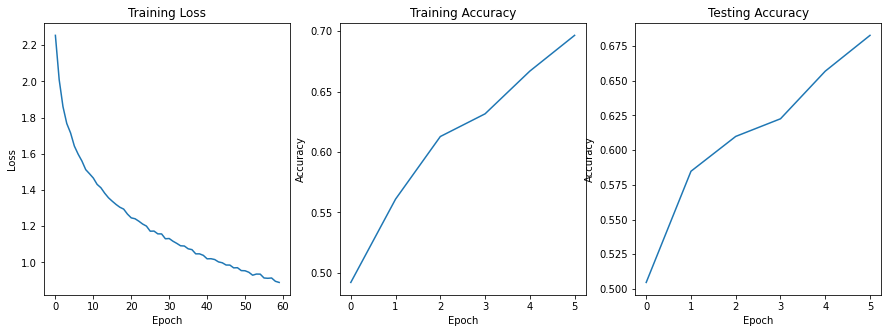

In [0]:
plot_results(train_losses_data_aug, train_accuracies_data_aug, test_accuracies_data_aug)

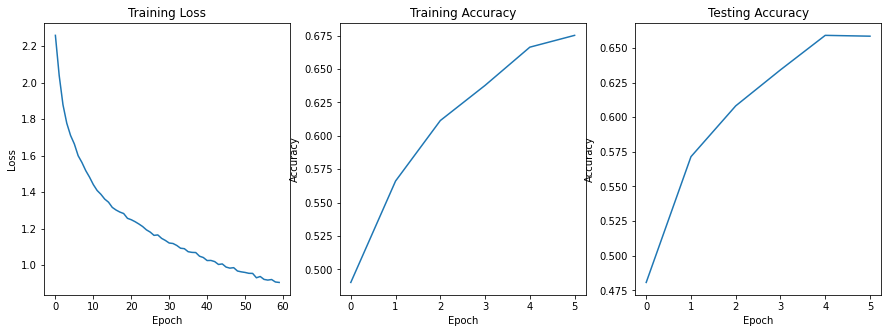

In [12]:
plot_results(train_losses_data_wo_aug, train_accuracies_data_wo_aug, test_accuracies_data_wo_aug)

**Question**: How does the model trained with data augmentation compared to the model trained without?

###Answer
Both the training set and testing set improve. Before doing data augmentation, we get the 67% on training set and 65% on testing set. After doing data augmentation, we get 70% on training set and 68% on testing set. In this case, we do three transformations, color, rotation and flipping. 


### 2.3.5. Change the loss function

Try Mean Squared Error loss instead of Cross Entropy.

In [0]:
class MSELossClassification(nn.Module):
  def forward(self, output, labels):
    one_hot_encoded_labels = \
      torch.nn.functional.one_hot(labels, num_classes=output.shape[1]).float()
    return nn.functional.mse_loss(output, one_hot_encoded_labels)

net = CoolNet()
train_losses_mse, train_accuracies_mse, test_accuracies_mse = train_network(
    net, 
    criterion=MSELossClassification(),
    lr=0.01, 
    epochs=50, 
    batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 0.096



Epoch 1 summary -- loss = 0.093



Epoch 2 summary -- loss = 0.092



Epoch 3 summary -- loss = 0.091



Epoch 4 summary -- loss = 0.090



Epoch 5 summary -- loss = 0.090



Epoch 6 summary -- loss = 0.089



Epoch 7 summary -- loss = 0.089



Epoch 8 summary -- loss = 0.089



Epoch 9 summary -- loss = 0.089
Evaluating epoch 10



Train accuracy of the network: 18.93%
Train accuracy of plane = 17.50%
Hard negatives for plane
Train accuracy of car = 15.40%
Hard negatives for car
Train accuracy of bird = 0.36%
Hard negatives for bird
Train accuracy of cat = 4.18%
Hard negatives for cat
Train accuracy of deer = 1.54%
Hard negatives for deer
Train accuracy of dog = 25.82%
Hard negatives for dog
Train accuracy of frog = 41.74%
Hard negatives for frog
Train accuracy of horse = 42.10%
Hard negatives for horse
Train accuracy of ship = 8.26%
Hard negatives for ship
Train accuracy of truck = 32.40%
Hard negatives for truck



Test accuracy of the network: 19.09%
Test accuracy of plane = 16.60%
Hard negatives for plane
Test accuracy of car = 16.80%
Hard negatives for car
Test accuracy of bird = 0.30%
Hard negatives for bird
Test accuracy of cat = 4.20%
Hard negatives for cat
Test accuracy of deer = 0.40%
Hard negatives for deer
Test accuracy of dog = 26.60%
Hard negatives for dog
Test accuracy of frog = 42.20%
Hard negatives for frog
Test accuracy of horse = 43.10%
Hard negatives for horse
Test accuracy of ship = 8.80%
Hard negatives for ship
Test accuracy of truck = 31.90%
Hard negatives for truck



Epoch 10 summary -- loss = 0.089



Epoch 11 summary -- loss = 0.088



Epoch 12 summary -- loss = 0.088



Epoch 13 summary -- loss = 0.088



Epoch 14 summary -- loss = 0.088



Epoch 15 summary -- loss = 0.088



Epoch 16 summary -- loss = 0.088



Epoch 17 summary -- loss = 0.087



Epoch 18 summary -- loss = 0.087



Epoch 19 summary -- loss = 0.087
Evaluating epoch 20



Train accuracy of the network: 24.86%
Train accuracy of plane = 37.14%
Hard negatives for plane
Train accuracy of car = 18.34%
Hard negatives for car
Train accuracy of bird = 1.34%
Hard negatives for bird
Train accuracy of cat = 9.08%
Hard negatives for cat
Train accuracy of deer = 5.76%
Hard negatives for deer
Train accuracy of dog = 25.10%
Hard negatives for dog
Train accuracy of frog = 43.34%
Hard negatives for frog
Train accuracy of horse = 29.12%
Hard negatives for horse
Train accuracy of ship = 23.02%
Hard negatives for ship
Train accuracy of truck = 56.36%
Hard negatives for truck



Test accuracy of the network: 24.71%
Test accuracy of plane = 39.20%
Hard negatives for plane
Test accuracy of car = 18.40%
Hard negatives for car
Test accuracy of bird = 1.00%
Hard negatives for bird
Test accuracy of cat = 8.40%
Hard negatives for cat
Test accuracy of deer = 3.60%
Hard negatives for deer
Test accuracy of dog = 25.60%
Hard negatives for dog
Test accuracy of frog = 44.40%
Hard negatives for frog
Test accuracy of horse = 27.90%
Hard negatives for horse
Test accuracy of ship = 22.60%
Hard negatives for ship
Test accuracy of truck = 56.00%
Hard negatives for truck



Epoch 20 summary -- loss = 0.087



Epoch 21 summary -- loss = 0.087



Epoch 22 summary -- loss = 0.087



Epoch 23 summary -- loss = 0.087



Epoch 24 summary -- loss = 0.086



Epoch 25 summary -- loss = 0.086



Epoch 26 summary -- loss = 0.086



Epoch 27 summary -- loss = 0.086



Epoch 28 summary -- loss = 0.086



Epoch 29 summary -- loss = 0.086
Evaluating epoch 30



Train accuracy of the network: 27.16%
Train accuracy of plane = 42.82%
Hard negatives for plane
Train accuracy of car = 22.70%
Hard negatives for car
Train accuracy of bird = 1.52%
Hard negatives for bird
Train accuracy of cat = 10.24%
Hard negatives for cat
Train accuracy of deer = 8.76%
Hard negatives for deer
Train accuracy of dog = 25.64%
Hard negatives for dog
Train accuracy of frog = 42.22%
Hard negatives for frog
Train accuracy of horse = 27.68%
Hard negatives for horse
Train accuracy of ship = 31.84%
Hard negatives for ship
Train accuracy of truck = 58.16%
Hard negatives for truck



Test accuracy of the network: 26.97%
Test accuracy of plane = 43.50%
Hard negatives for plane
Test accuracy of car = 22.50%
Hard negatives for car
Test accuracy of bird = 1.10%
Hard negatives for bird
Test accuracy of cat = 9.50%
Hard negatives for cat
Test accuracy of deer = 7.00%
Hard negatives for deer
Test accuracy of dog = 27.50%
Hard negatives for dog
Test accuracy of frog = 43.40%
Hard negatives for frog
Test accuracy of horse = 26.30%
Hard negatives for horse
Test accuracy of ship = 31.20%
Hard negatives for ship
Test accuracy of truck = 57.70%
Hard negatives for truck



Epoch 30 summary -- loss = 0.086



Epoch 31 summary -- loss = 0.086



Epoch 32 summary -- loss = 0.086



Epoch 33 summary -- loss = 0.085



Epoch 34 summary -- loss = 0.085



Epoch 35 summary -- loss = 0.085



Epoch 36 summary -- loss = 0.085



Epoch 37 summary -- loss = 0.085



Epoch 38 summary -- loss = 0.085



Epoch 39 summary -- loss = 0.085
Evaluating epoch 40



Train accuracy of the network: 28.97%
Train accuracy of plane = 43.90%
Hard negatives for plane
Train accuracy of car = 26.12%
Hard negatives for car
Train accuracy of bird = 2.48%
Hard negatives for bird
Train accuracy of cat = 10.48%
Hard negatives for cat
Train accuracy of deer = 12.30%
Hard negatives for deer
Train accuracy of dog = 27.26%
Hard negatives for dog
Train accuracy of frog = 41.76%
Hard negatives for frog
Train accuracy of horse = 29.00%
Hard negatives for horse
Train accuracy of ship = 38.16%
Hard negatives for ship
Train accuracy of truck = 58.22%
Hard negatives for truck



Test accuracy of the network: 28.84%
Test accuracy of plane = 45.30%
Hard negatives for plane
Test accuracy of car = 26.30%
Hard negatives for car
Test accuracy of bird = 2.00%
Hard negatives for bird
Test accuracy of cat = 9.90%
Hard negatives for cat
Test accuracy of deer = 10.70%
Hard negatives for deer
Test accuracy of dog = 28.90%
Hard negatives for dog
Test accuracy of frog = 42.40%
Hard negatives for frog
Test accuracy of horse = 27.20%
Hard negatives for horse
Test accuracy of ship = 38.00%
Hard negatives for ship
Test accuracy of truck = 57.70%
Hard negatives for truck



Epoch 40 summary -- loss = 0.085



Epoch 41 summary -- loss = 0.085



Epoch 42 summary -- loss = 0.084



Epoch 43 summary -- loss = 0.084



Epoch 44 summary -- loss = 0.084



Epoch 45 summary -- loss = 0.084



Epoch 46 summary -- loss = 0.084



Epoch 47 summary -- loss = 0.084



Epoch 48 summary -- loss = 0.084



Epoch 49 summary -- loss = 0.084
Evaluating epoch 50



Train accuracy of the network: 30.68%
Train accuracy of plane = 44.22%
Hard negatives for plane
Train accuracy of car = 30.28%
Hard negatives for car
Train accuracy of bird = 4.48%
Hard negatives for bird
Train accuracy of cat = 10.96%
Hard negatives for cat
Train accuracy of deer = 14.44%
Hard negatives for deer
Train accuracy of dog = 29.24%
Hard negatives for dog
Train accuracy of frog = 42.78%
Hard negatives for frog
Train accuracy of horse = 31.34%
Hard negatives for horse
Train accuracy of ship = 41.58%
Hard negatives for ship
Train accuracy of truck = 57.46%
Hard negatives for truck



Test accuracy of the network: 30.56%
Test accuracy of plane = 45.60%
Hard negatives for plane
Test accuracy of car = 31.00%
Hard negatives for car
Test accuracy of bird = 3.30%
Hard negatives for bird
Test accuracy of cat = 11.30%
Hard negatives for cat
Test accuracy of deer = 12.90%
Hard negatives for deer
Test accuracy of dog = 29.80%
Hard negatives for dog
Test accuracy of frog = 43.10%
Hard negatives for frog
Test accuracy of horse = 29.10%
Hard negatives for horse
Test accuracy of ship = 42.80%
Hard negatives for ship
Test accuracy of truck = 56.70%
Hard negatives for truck


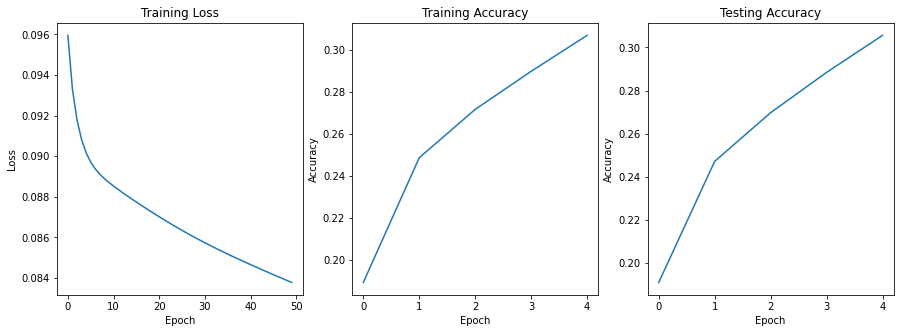

In [0]:
plot_results(train_losses_mse, train_accuracies_mse, test_accuracies_mse)

**Question**:
How does this affects the results? Explain why you think this is happening.

###Answer
In the result, MSE given a lower loss starting from 0.096 and descend in a minimum speed. However, Cross Entropy given a greater loss and descending in a greater speed which makes the model is truely learning from the data set.

Generally, MSE gives a smaller loss and Cross Entropy gives a greater loss. We use MSE to train on a regression model and use Cross Entropy on classification model which will give a more reasonable result.

## Turning In

You're done! You just need to turn in the notebook file.

Go to `File > Download .ipynb` and download the file as `hw4.ipynb`. Turn in only this file.

Make sure that you've answered all questions and all plots are correct.